# Painters Recognition from Artworks - Advanced Machine Learning
L'obiettivo del progetto è quello di implementare dei modelli di Deep Learning basati su reti convoluzionali in grado di riconoscre l'autore di un dipinto a partire dalle sue caratteristiche, come ad esempio il colore  e lo stile.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DRIVE_PATH = '...'
IMAGE_PATH = '...'
DATA_PATH = '...'
MODEL_PATH = '...'

In [ ]:
%%capture
!pip install keras_tuner
!pip install visualkeras

In [ ]:
# Gestione ed estrazione file
import os
import pandas as pd
import numpy as np
import random
import zipfile
import shutil
from keras.preprocessing.image import image_dataset_from_directory

# Plot immagini
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns

# Neural Network
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import Model 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPool2D, PReLU
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D
from tensorflow.keras.metrics import Recall
from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.initializers import GlorotUniform
# Tuning iper-parametri
import keras_tuner as kt
import visualkeras

# Valutazione risultati
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

## Selezione artisti e Preprocessing
Il dataset utilizzato per il progetto è stato scaricato da [Kaggle](https://www.kaggle.com/ikarus777/best-artworks-of-all-time) e contiene i dipinti di 50 pittori internazionali, per un totale di 8446 quadri.
I dipinti presenti si differenziamo molto tra di loro per dimensione, ma anche per colore e stile.

In [ ]:
def load_zip(path, filename, delete_zip = False):
  """
  Funzione per copiare ed estrarre in locale i file .zip. Il file originale, se
  richiesto, viene eliminato.
  
  :param str path: Percorso per lo zip
  :param str filename: Nome dello zip
  :param boolean delete_zip: True per eliminare il file .zip scaricato
  """

  shutil.copyfile(path, filename)

  # Estrazione dello zip
  zip = zipfile.ZipFile(filename)
  zip.extractall()
  zip.close()

  # Rimozione zip se richiesto
  if delete_zip:
    os.remove(filename)

In [ ]:
# Download zip dei dati
load_zip(DRIVE_PATH + 'Paintings.zip', 'Paintings.zip')

In [ ]:
artists = pd.read_csv('./artists.csv')

[]

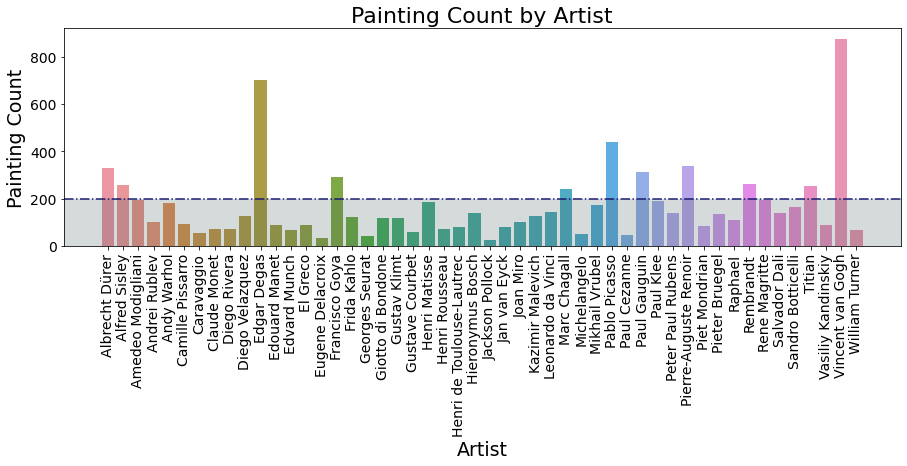

In [ ]:
artists = artists.sort_values(by=['name'], ascending=True)

figsize=(15, 4)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

xlabel = "Artist"
ylabel = "Painting Count"

title = "Painting Count by Artist"


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

col1 = "name"
col2 = "paintings"

sns.barplot(x=col1, y=col2, data=artists)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.axhline(y=200, color='midnightblue', linestyle='-.')
plt.axhspan(0, 200, facecolor ='darkslategrey', alpha = 0.2)
plt.plot()

Come si può osservare dalla figura sopra la maggior parte degli artisti ha meno di 200 quadri e addirittura solo due ne hanno più di 600, Degas e Vang Gogh. Considerando tutti i pittori, il dataset risultante risulterebbe oltremodo sbilanciato e computazionalmente ci causerebbe delle limitazioni. Per tale ragione si è convenuto di considerare solo gli artisti aventi più di $200$ dipinti; così facendo sono stati mantenuti 11 artisti per un totale di circa $4300$ immagini.

In [ ]:
# Sorting dataframe artists per numero di quadri 
artists = artists.sort_values(by=['paintings'], ascending=False)

# Creazione dataframe artists_top per autori con più di 200 quadri
artists_top = artists[artists['paintings'] >= 200].reset_index() 
artists_top = artists_top[['name', 'paintings']]

In [ ]:
artists_top

,name,paintings
0,Vincent van Gogh,877
1,Edgar Degas,702
2,Pablo Picasso,439
3,Pierre-Auguste Renoir,336
4,Albrecht Dürer,328
5,Paul Gauguin,311
6,Francisco Goya,291
7,Rembrandt,262
8,Alfred Sisley,259
9,Titian,255


In [ ]:
pittori = [p.replace(' ', '_') for p in artists_top.name]
num_classes = len(pittori)

In [ ]:
# Verifica di una cartella col nome errato
( len(sorted(os.listdir('/content/images/images/Albrecht_DuΓòá├¬rer'))) ==
 len(sorted(os.listdir('/content/images/images/Albrecht_Du╠êrer'))) )

True

Poichè all'interno del dataset è presente una cartella con un nome errato, '*Albrecht DuΓòá├¬rer*' invece che '*Albrecht Durer*', nella funzione che segue si è provveduto a correggere l'errore. \
Il dataset originario non era suddiviso in Training e Test, così abbiamo provveduto noi ad effettuare la suddivisione, mantenendo una parcentuale di $80-20$.

In [ ]:
def split_train_test(path_images, painters, train_path, test_path, frac = 0.2):
  """
  Dalla cartella contenente tutte le immagini, vengono generate due sotto-cartelle 
  per il training e per il testing.

  :param str path_images: path della cartella contenente tutte le immagini
  :param list painters: lista di stringhe (nomi dei pittori selezionati)
  :param str train_path: path destinazione per il train set
  :param str test_path: path destinazione per il test set
  :param float frac: frazione delle immagini in path_images che verranno
  spostate in test_path; 1-frac sono le restanti immagini spostate nel train set
  """
  if not os.path.isdir(test_path):
    os.makedirs(test_path)

  # Rinominazione cartella errata
  source = '/content/images/images/Albrecht_DuΓòá├¬rer'
  dest = '/content/images/images/Albrecht_Dürer'
  try:
    os.rename(source, dest)
    print('Cartella errata rinominata correttamente in "' + dest + '";')
    print('\n~~~~~ Modifica nomi file in cartella "' + dest + '" ~~~~~')
    os.chdir(dest)
    for f in sorted(os.listdir(dest + '/')):
      os.rename(f, f.replace('uΓòá├¬', 'ü'))
    print('\nFile in cartella errata rinominati correttamente.')
  except OSError as error:
    print(error)

  # Cartelle pittori
  folders = sorted(os.listdir(path_images))
  print('\n\n~~~~~ Creazione cartelle di  train e di test ~~~~~')
  for f in folders:

    # Selezione solo pittori in painters
    if f in painters:

      # Creazione Test set
      if not os.path.isdir(test_path + f):
        os.makedirs(test_path + f)

      painter_dir = path_images + f + '/'
      painter_file = os.listdir(path_images + f)
      # Numero di quadri per il test
      num_sample = round(len(painter_file)*frac)
      # Quadri selezionati per il test
      paintings = random.sample(painter_file, num_sample)

      for p in paintings:
        shutil.move(painter_dir + p, test_path + f + '/' + p)
      
      # Creazione Train set
      if not os.path.isdir(train_path + f):
        os.makedirs(train_path + f)

      # Istanziazione nuova variabile per file in f
      painter_file = os.listdir(path_images + f)
      # Move per i file restanti in train_path
      for p in painter_file:
        shutil.move(painter_dir + p, train_path + f + '/' + p)

  print('\nCompletamento creazione cartelle.')

In [ ]:
split_train_test(IMAGE_PATH, pittori, train_path = DRIVE_PATH + 'Data/Train/',
                 test_path = DRIVE_PATH + 'Data/Test/', frac = 0.2)

Cartella errata rinominata correttamente in "/content/images/images/Albrecht_Dürer";

~~~~~ Modifica nomi file in cartella "/content/images/images/Albrecht_Dürer" ~~~~~

File in cartella errata rinominati correttamente.


~~~~~ Creazione cartelle di  train e di test ~~~~~

Completamento creazione cartelle.


In [ ]:
print('Numero pittori in Train set: ',
      str(len(sorted(os.listdir(DRIVE_PATH + 'Data/Train/')))))
print('\nNumero pittori in Test set: ',
      str(len(sorted(os.listdir(DRIVE_PATH + 'Data/Test/')))))

Numero pittori in Train set:  11

Numero pittori in Test set:  11


In [ ]:
sample_train = [p-round(p*0.2) for p in
                artists[artists['paintings'] >= 200].reset_index().paintings]
sample_test = [round(p*0.2) for p in
               artists[artists['paintings'] >= 200].reset_index().paintings]

Il dataframe precedentemente creato, `artisti_top` è stato aggiornato con l'aggiunta di tre colonne:
- *train*, il numero di quadri del relativo artista nel training set;
- *test*, il numero di quadri del relativo artista nel testing set;
- *class_weight*, il peso che ha ciascun artisa nel dataset in base al numero di quadri. 
Quest'ultima variabile viene calcolata come $\frac{numero\ quadri\ totale\ nel\ train}{numero\ artisti\ \times numero\ quadri\ per\ artista }$

In [ ]:
artists_top = artists_top.rename(columns={"paintings": "tot_paintings"})
artists_top['train'] = sample_train
artists_top['test'] = sample_test
# Creazione variabile di peso
artists_top['class_weight'] = artists_top.train.sum() / (artists_top.shape[0] *
                                                         artists_top.train)

In [ ]:
artists_top

,name,tot_paintings,train,test,class_weight
0,Vincent van Gogh,877,702,175,0.445480
1,Edgar Degas,702,562,140,0.556454
2,Pablo Picasso,439,351,88,0.890961
3,Pierre-Auguste Renoir,336,269,67,1.162555
4,Albrecht Dürer,328,262,66,1.193616
5,Paul Gauguin,311,249,62,1.255933
6,Francisco Goya,291,233,58,1.342177
7,Rembrandt,262,210,52,1.489177
8,Alfred Sisley,259,207,52,1.510760
9,Titian,255,204,51,1.532977


In [ ]:
# Creazione dizionario con i pesi
CLASS_WEIGHTS = artists_top['class_weight'].to_dict()

In [ ]:
CLASS_WEIGHTS

{0: 0.44548044548044546,
 1: 0.556454221934649,
 2: 0.8909608909608909,
 3: 1.1625549172017573,
 4: 1.193615544760583,
 5: 1.2559328221978825,
 6: 1.3421771361685524,
 7: 1.4891774891774892,
 8: 1.5107597716293368,
 9: 1.5329768270944741,
 10: 1.6373155640171346}

Abbiamo deciso di mantenere sbilanciate le 11 classi del dataset, ma di specificare durante il *fit* dei modelli il parametro `class_weigths` che tiene conto del peso di ciascuna classe all'interno del dataset.

In [ ]:
# Lista coi nomi dei pittori selezionati in ordine alfabetico
labels = list(artists_top.name.sort_values())

## Data Loader
In questa sezione viene definita la funzione che permette il caricamento dei dati. In fase di caricamento questi vengono ridimensionati, così da avere una dimensione di $224\times224$. I dati infine vengono caricati in *batch* da $64$ ed è stato imposto un *validation_split* pari a $0.1$.

In [ ]:
def import_data(train_path, test_path, img_size = (224,224), batch_size = 64,
                val_split = 0.1):
  """
  Importa le immagini di training, validation e test per il modello attraverso
  l'ImageDataGenerator di Keras. 
  
  :param int img_size: dimensione delle immagini
  :param str batch_size: dimensione dei batch per i set
  :param float val_split: dimensione del validation test
  :param str train_path: percorso della cartella contenente le immagini di training
  :param str test_path: percorso della cartella contenente le immagini di test
  """
  print('~~~~~~~~ Caricamento TRAIN SET ~~~~~~~~')
  train_set = keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size = img_size,
    color_mode = 'rgb',
    batch_size = batch_size,
    label_mode = 'categorical',
    shuffle = True,
    validation_split = val_split,
    subset = 'training',
    seed = 1)
  
  print('\n\n~~~~~~~~ Caricamento VALIDATION SET ~~~~~~~~')
  val_set = keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size = img_size,
    color_mode = 'rgb',
    batch_size = batch_size,
    label_mode = 'categorical',
    shuffle = True,
    validation_split = val_split,
    subset = 'validation',
    seed = 1)
  
  print('\n\n~~~~~~~~ Caricamento TEST SET ~~~~~~~~')
  test_set = keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = img_size,
    color_mode = 'rgb',
    batch_size = batch_size,
    label_mode = 'categorical',
    shuffle = False,
    seed = 1)
  
  return train_set, val_set, test_set

In [ ]:
train_set, val_set, test_set = import_data(train_path = DATA_PATH + 'Train',
                                           test_path = DATA_PATH + 'Test')

~~~~~~~~ Caricamento TRAIN SET ~~~~~~~~
Found 3440 files belonging to 11 classes.
Using 3096 files for training.


~~~~~~~~ Caricamento VALIDATION SET ~~~~~~~~
Found 3440 files belonging to 11 classes.
Using 344 files for validation.


~~~~~~~~ Caricamento TEST SET ~~~~~~~~
Found 859 files belonging to 11 classes.


In [ ]:
# Ispezione della dimensione degli elementi del dataset
train_set.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))

In [ ]:
# Estrazione delle labels dal test set
y_test = np.concatenate([y for x, y in test_set], axis=0)
y_test = [np.argmax(l) for l in y_test]

In [ ]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 11

### Visualizzazione contenuto del dataset


Segue una visualizzazione di 9 dipinti entratti casualmente dal dataset.
Come si può osservare le immagini ridimensionate durante il caricamento ora hanno tutta la stessa dimensione ($224 \times 224$).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


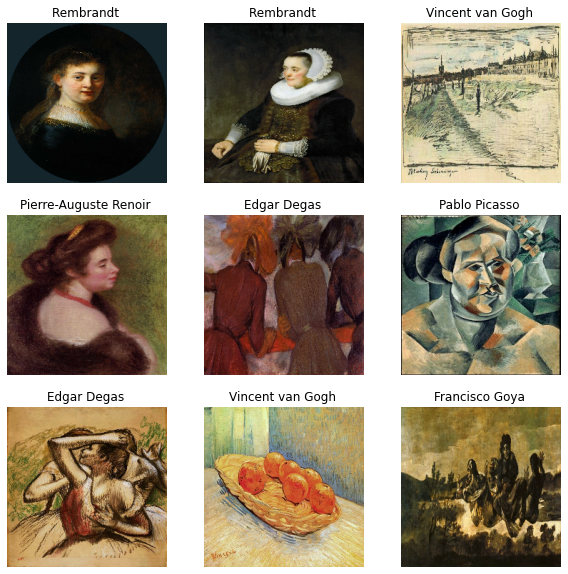

In [ ]:
class_names = train_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(4):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    author = class_names[labels[i]].split('_')
    title = ''
    for i in range(len(author)):
      title = title + author[i] + ' '
    plt.title(title)
    plt.axis("off")

## Funzioni ausiliarie
In questa sezione sono raccolte una serie di funzioni che ci saranno utili in fase di addestramento e valutazione dei modelli. In particolare svolgono i seguenti compiti:
- addestramento del modello con la possibilità di scegliere se usare l'Early Stopping;
- calcolo della predizione;
- plot delle curve di loss e accuracy per il training e il validation set;
- visualizzazione dei risultati attraverso una serie di metriche e il plot della matrice di confusione.

In [ ]:
def train_model(model, bs = 128, eps = 50, early_stopping = True, pat = 3,
                min_d = 0.001):
  """
  Viene eseguito il fit del modello su un numero di epoche fissato.
  :param keras.engine.functional.Functional model: modello da addestrare
  :param int bs: batch size
  :param int eps: numero di epoche desiderato
  :param bool early_stopping: parametro booleano che specifica se utilizzare o
  meno l'Early Stopping
  :param int pat: numero di epoche da eseguire se non si verificano miglioramenti
  :param float min_d: variazione minima richiesta
  """
  early_stop = None
  if early_stopping == True:
    early_stop = EarlyStopping(monitor = 'val_loss', patience = pat,
                               min_delta = min_d, restore_best_weights = True,
                               verbose = 1) 

    history = model.fit(train_set, epochs = eps, validation_data = val_set,
                        batch_size = bs, class_weight = CLASS_WEIGHTS,
                        callbacks = [early_stop], verbose = 1)
    
  else:
    history = model.fit(train_set, epochs = eps, validation_data = val_set,
                        batch_size = bs, class_weight = CLASS_WEIGHTS,
                        verbose = 1)
  return history, early_stop

In [ ]:
def plot_history(history, early_stop = None, plot_size = (15,5)):
  """
  Visualizza a video alcune informazioni testuali di base sul training del
  modello e due grafici per analizzare l'andamento della loss e dell'accuracy
  durante il training
  
  :param keras.callbacks.History history: history del modello contenente i valori 
  di loss e accuracy per training e validation set
  :param keras.callbacks.EarlyStopping early_stop: early stopping utilizzato in
  fase di addestramento
  :param tuple plot_size: dimensione del plot
  """

  if early_stop is not None:
    if early_stop.stopped_epoch != 0:
      epochs = early_stop.stopped_epoch + 1
    else:
      early_stop.best_epoch + 1
    best_epoch = early_stop.best_epoch + 1
  else:
    epochs = len(history.epoch)
    best_epoch = epochs

  fig = plt.figure(figsize = plot_size)

  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs'); plt.ylabel('Loss');  plt.title('Model loss')
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  plt.plot(range(0,best_epoch,1), 
           history.history['loss'][:best_epoch], '.-', color="C0") 
  plt.plot(range(0,best_epoch,1), 
           history.history['val_loss'][:best_epoch], '.-', color="C1")
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['loss'][best_epoch-1:], '.--', color="C0") 
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_loss'][best_epoch-1:], '.--', color="C1")
  plt.legend(['Training', 'Validation'])

  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs'); plt.ylabel('Accuracy');  plt.title('Model accuracy')
  plt.xticks(np.arange(len(history.epoch)), np.arange(1, len(history.epoch)+1))
  plt.plot(range(0,best_epoch,1), 
           history.history['accuracy'][:best_epoch], '.-', color="C0") 
  plt.plot(range(0,best_epoch,1), 
           history.history['val_accuracy'][:best_epoch], '.-', color="C1")
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['accuracy'][best_epoch-1:], '.--', color="C0") 
  plt.plot(range(best_epoch-1, len(history.epoch),1), 
           history.history['val_accuracy'][best_epoch-1:], '.--', color="C1") 
  plt.legend(['Training', 'Validation'], loc='lower right')

  print('Informazioni utili: \n')
  print('Numero di epoche totali:', epochs)
  print('Epoca migliore (weights restored):', best_epoch)
  print('Accuracy training set all\'epoca ' + str(best_epoch) + ': ' 
        + str(history.history['accuracy'][best_epoch -1]))
  print('Accuracy validation set all\'epoca ' + str(best_epoch) + ': '
        + str(history.history['val_accuracy'][best_epoch -1]))
  print('Loss training set all\'epoca ' + str(best_epoch) + ': '
        + str(history.history['loss'][best_epoch -1]))
  index = history.history['val_loss'].index(early_stop.best)
  print('Loss validation set all\'epoca ' + str(best_epoch) + ': ' 
        + str(history.history['val_loss'][index]))
  print('\n\n')

In [ ]:
def make_prediction(model, test_set):
  """
  Determina la classificazione per il test set dato un modello
  :param keras.engine.functional.Functional model: modello usato per la
  classificazione
  :param BatchDataset: testing set
  """
  y_prediction = model.predict(test_set)
  y_pred = []
  for i in range(len(y_prediction)):
    y_pred.append(np.argmax(y_prediction[i]))
  y_pred = np.array(y_pred)

  return y_pred

In [ ]:
def evaluate_prediction(model, y_test, y_pred, labels, plot_size = (15,15)):
  """
  Calcola e visualizza graficamente alcune metriche sulle predizioni
  
  :param keras.engine.functional.Functional model: modello keras trainato con
  cui effettuare le predizioni
  :param string y_test: lista contenente le label del test set
  :param string y_pred: lista contenente le label della classificazione
  :param string labels: lista contenente i nomi dei pittori
  """
  # Classification report
  cl = classification_report(y_test, y_pred, target_names = labels)
  print('\nClassification Report\n', cl)

  # Confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  fig, ax = plt.subplots(figsize=plot_size)
  sns.heatmap(cm, annot=True, fmt='g', cmap="PuRd") 
  ax.set_title('Confusion Matrix');
  ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');
  ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
  plt.xticks(rotation='vertical'); plt.yticks(rotation='horizontal')


## Neural Network <i>from scratch</i>

Per lo svolgimento del progetto il primo approccio affrontato è stato costruire una rete da zero, in modo che potesse essere utilizzata come base di confronto per gli altri modelli (da qui il nome `baseline`).<br>
Dopo aver istanziato, addestrato e testato la rete si è cercato di migliorare le prestazioni del modello andando ad applicare un <i>fine tuning</i> dei suoi iperparametri. Nelle due sezioni successive viene raccolto il codice che implementa le due strade appena descritte.

### Modello <i>baseline</i>
Come anticipato, per generare un modello di base che potesse essere utilizzato come punto di partenza e come possibile confronto con modelli più sofisticati, si è deciso di implementare un modello <i>from scratch</i> che è stato ripreso dal lavoro di [Viswanathan](http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf).<br>
In particolare la rete, con un dimensione di input pari a $(224\times 224\times 3)$, è composta da due blocchi convoluzionali, con layer costituiti entrambi da $32$ filtri $3\times 3$ con <i>stride</i> impostato a $2$, a cui sono collegati dei layer di <i>max pooling</i> che permettano un downsampling delle immagini in input con dei filtri $2\times 2$. Successivamente ai due blocchi convoluzionali, dopo un layer <i>flatten</i> che appiattisce la matrice in input in un vettore monodimensionale, è stato inserito un layer <i>fully connected</i> a $228$ unità. Infine si trova il layer di output con un numero di neuroni uguale al numero di classi da classificare ($11$), per cui è stata selezionata <i>softmax</i> come funzione di attivazione dal momento che il task richiede una classificazione multiclasse. Proprio per questo ultimo motivo si è deciso di utilizzare come funzione di perdita la <i>categorical crossentropy</i>.

In [ ]:
### Baseline network ###

# Reset sezione
keras.backend.clear_session()
keras.backend.reset_uids()

# Input layer
in_ = keras.Input(shape = INPUT_SHAPE)

# I blocco convoluzionale
conv_1 = Conv2D(32, kernel_size = 3, strides = 2, padding = 'same',
                activation = 'relu')(in_)
pool_1 = MaxPool2D(pool_size = (2,2))(conv_1)

# II blocco convoluzionale
conv_2 = Conv2D(32, kernel_size = 3, strides = 2, padding = 'same',
                activation = 'relu')(pool_1)
pool_2 = MaxPool2D(pool_size = (2,2))(conv_2)

# FC layer
fl = Flatten()(pool_2)
fc_1 = Dense(228, activation = 'relu')(fl)
out_ = Dense(num_classes, activation = 'softmax')(fc_1)

# Definizione modello
baseline = keras.Model(inputs = in_, outputs = out_)

# Compilazione modello
baseline.compile(loss = keras.losses.categorical_crossentropy,
                 optimizer = keras.optimizers.Adam(0.0015),
                 metrics = ['accuracy', Recall(name = 'recall')])

Di seguito è riportata una rappresentazione schematica della rete appena descritta.

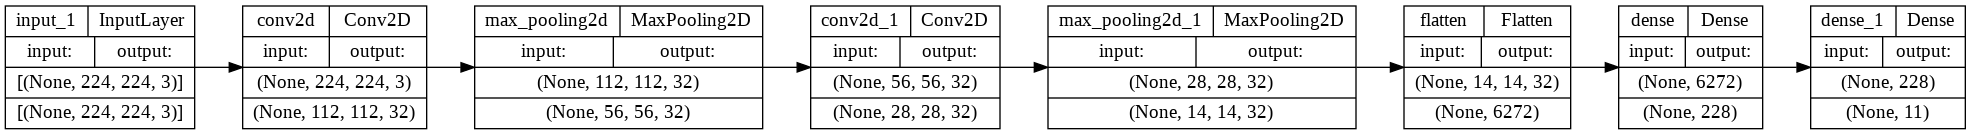

In [ ]:
# Visualizzazione modello Baseline
keras.utils.plot_model(baseline, show_shapes=True, rankdir= 'LR')

Richiamando la funzione `train_model` definita nelle sezioni precedenti, è stato possibile impostare l'addestramento della rete `baseline` per $50$ epoche.

In [ ]:
base_h, base_es = train_model(baseline, eps = 50, early_stopping = True, pat = 3)

Epoch 1/50


2022-02-19 14:19:31.627887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


49/49 [==============================] - 36s 497ms/step - loss: 22.5050 - accuracy: 0.1944 - recall: 0.0349 - val_loss: 2.1849 - val_accuracy: 0.2674 - val_recall: 0.1105
Epoch 2/50
49/49 [==============================] - 19s 337ms/step - loss: 2.1183 - accuracy: 0.3547 - recall: 0.1379 - val_loss: 2.0427 - val_accuracy: 0.3110 - val_recall: 0.1948
Epoch 3/50
49/49 [==============================] - 19s 340ms/step - loss: 1.5892 - accuracy: 0.4897 - recall: 0.3253 - val_loss: 1.9723 - val_accuracy: 0.3721 - val_recall: 0.1686
Epoch 4/50
49/49 [==============================] - 18s 326ms/step - loss: 1.1664 - accuracy: 0.6176 - recall: 0.4735 - val_loss: 2.1940 - val_accuracy: 0.3750 - val_recall: 0.2471
Epoch 5/50
49/49 [==============================] - 19s 338ms/step - loss: 0.8550 - accuracy: 0.7219 - recall: 0.6114 - val_loss: 2.3705 - val_accuracy: 0.4012 - val_recall: 0.2849
Epoch 6/50
49/49 [==============================] - 19s 333ms/step - loss: 0.5919 - accuracy: 0.8036 - re

Per l'addestramento della rete è stato utilizzato un <i>eraly stopping</i>, un meccanismo per il quale, superato il limite di epoche `patience=3` per cui l'addestramento non migliora i risultati della loss sul validation di almeno `min_delta = 0.01`, l'addestramento viene interrotto. Dal momento che il training sulla rete, ottenuto il migliore risultato alla $3°$, non è più migliorato per le successive $3$ epoche, l'early stopping ne ha interrotto l'addestramento dopo appena $6$ epoche.<br>
Il comportamento dell'addestramento di può osservare meglio dai grafici riportati di seguito.

Informazioni utili: 

Numero di epoche totali: 6
Epoca migliore (weights restored): 3
Accuracy training set all'epoca 3: 0.48966407775878906
Accuracy validation set all'epoca 3: 0.3720930218696594
Loss training set all'epoca 3: 1.589228868484497
Loss validation set all'epoca 3: 1.9723176956176758





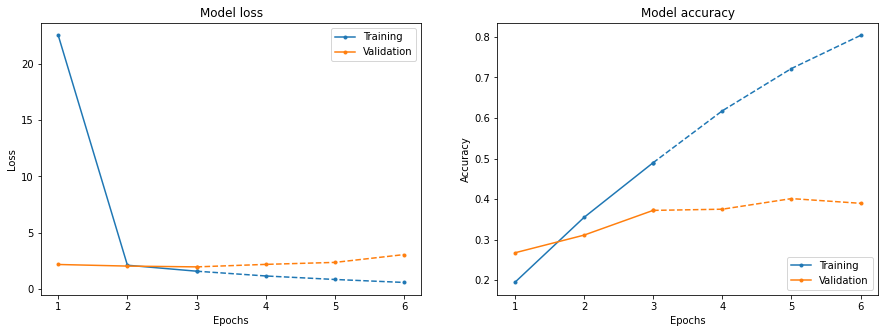

In [ ]:
plot_history(base_h, early_stop = base_es)

Come si può notare dalle immagini, dalla $3°$ epoca le due curve di training e validation, sia per l'accuracy che per la loss, inizino ad allontanarsi, aumentando il divario e portando ad un sempre più distinto overfitting. Tuttavia, come anticipato precedentemente, con l'intervento dell'early stopping il training del modello è stato interrotto, ripristinando la configurazione ottima ottenuta alla $3°$ epoca.

In [ ]:
base_pred = make_prediction(baseline, test_set)

Svolta la previsione sul test set, si è passati alla valutazione delle performance della rete.<br>
Come si può vedere dal report delle metriche riportato di seguito, la rete `baseline` ha ottenuto un'accuratezza sul test pari al $35\%$ con un forte sbilanciamento di classificazione verso la classe predominante di <i>van Gogh</i>. L'aggiunta del parametro `class_weight` per bilanciare l'addestramento del modello non ha portato benefici effettivi. Questo comportamento è molto ben visibile nella matrice di confusione riportata, in cui si può osservare come la maggior parte dei quadri in input siano stati classificati come appartenenti a <i>van Gogh</i>.

<a name="cm_baseline"></a>


Classification Report
                        precision    recall  f1-score   support

       Albrecht Dürer       0.44      0.71      0.55        66
        Alfred Sisley       1.00      0.02      0.04        52
          Edgar Degas       0.39      0.19      0.26       140
       Francisco Goya       0.59      0.38      0.46        58
         Marc Chagall       0.49      0.38      0.42        48
        Pablo Picasso       0.34      0.25      0.29        88
         Paul Gauguin       0.27      0.10      0.14        62
Pierre-Auguste Renoir       0.15      0.19      0.17        67
            Rembrandt       0.41      0.31      0.35        52
               Titian       0.43      0.29      0.35        51
     Vincent van Gogh       0.31      0.63      0.42       175

             accuracy                           0.35       859
            macro avg       0.44      0.31      0.31       859
         weighted avg       0.40      0.35      0.32       859



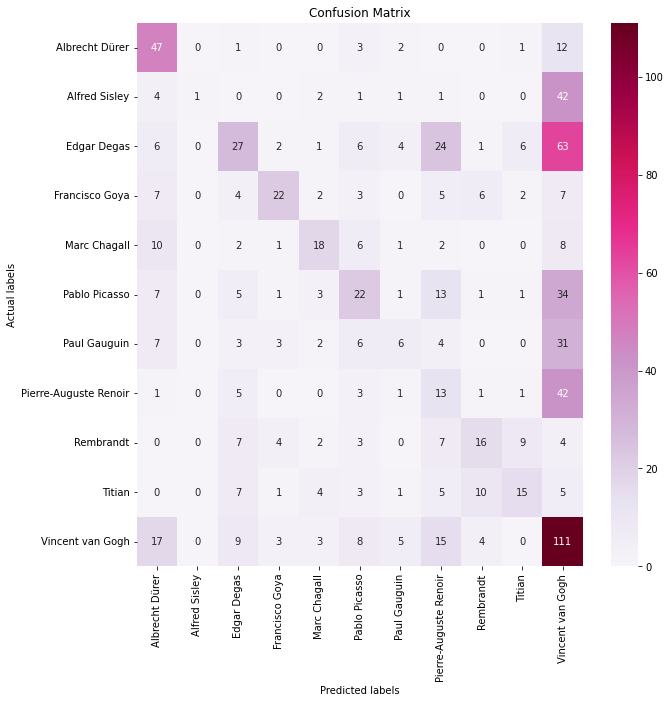

In [ ]:
evaluate_prediction(baseline, y_test, base_pred, labels, plot_size = (10,10))

### Modello <i>baseline</i> | Ottimizzazione iperparametri
Per cercare di migliorare i risultati ottenuti nel paragrafo precedente con la rete `baseline` si è deciso di cercare di ottimizzarne gli iperparametri, con la possibilità di aggiungere anche dei nuovi layer.<br>
Per fare ciò si è utilizzata la libreria python `keras_tuner` che, definito uno spazio di ricerca di iperparametri del modello, permette di trovare la configurazione ottima rispetto ad un determinato parametro.

In [ ]:
early_stop = EarlyStopping(monitor ='val_loss', patience = 3, min_delta = 15e-4,
                           verbose = 1, restore_best_weights = True) 

# Per garantire la replicabilità, impostazione seed casuale
initializer = GlorotUniform(seed=1234)

La funzione seguente definisce lo spazio di ricerca in cui viene ricercata la configurazione di iperparametri più adatta.

In [ ]:
def build_model(hp):
    
  # Reset sezione
  keras.backend.clear_session()
  keras.backend.reset_uids()

  model = keras.models.Sequential()

  # Input layer
  model.add(keras.Input(shape = INPUT_SHAPE))
  
  ### DEFINIZIONE IPERPARAMETRI ###
  act_functions = ["relu", "tanh"]
  n_filters = [16, 32, 64, 128]
  kernel_sz = [3, 5]
  drop_rate = [0.0, 0.2, 0.3]
  n_units = [64, 128, 256]
  opt_functions = ['adam', 'SGD']
  
  pool_sz = (2,2)

  ### DEFINIZIONE DEL MODELLO ###

  # Funzione di attivazione
  hp_act_function = hp.Choice('activation', values = act_functions,
                              default = 'relu')
  if hp_act_function == 'PReLU':
    act_f = get_custom_objects().update({'PReLU': PReLU()})
  else:
    act_f = hp_act_function

  # Numero di blocchi convoluzionali
  hp_n_conv = hp.Int('num_conv', min_value = 1, max_value = 3, step = 1,
                     default = 2)
  
  for i in range(hp_n_conv):
      
    # Dimensione del filtro
    hp_filter = hp.Choice(f'filter_{i}', values = n_filters, default = 32)
    # Dimensione del kernel
    hp_kernel_sz = hp.Choice(f'size_{i}', values = kernel_sz, default = 3)

    # Inserimento layer convoluzionale
    model.add(
        Conv2D(hp_filter, hp_kernel_sz, strides = 2, padding = "same",
               activation = act_f, kernel_initializer = initializer))
    # Inserimento layer max pooling
    model.add(
        MaxPool2D(pool_size = pool_sz))
    
  # Frazione da droppare | Dropout 1
  hp_dropout_rate_1 = hp.Choice('dropout_1', values = drop_rate, default = 0.2)
  if hp_dropout_rate_1 != 0:
    model.add(Dropout(hp_dropout_rate_1))

  # Appiattimento input
  model.add(Flatten())
  
  # Aggiungere uno o più layer FC prima dell'output?
  hp_add_dense = hp.Boolean('add_dense')
  if hp_add_dense:
    # Numero di layer FC da aggiungere
    hp_n_dense = hp.Int('num_dense', min_value = 1, max_value = 2, step = 1,
                        default = 1, parent_name = 'add_dense',
                        parent_values = [True])
    
    for i in range(hp_n_dense):

      # Numero di unità in FC
      uns = hp.Choice(f"units_{i}", values = n_units, default = 128)
      # Funzione di attivazione FC
      act_f = hp.Choice(f"activation_{i}", ['relu', 'PReLU'])

      # Inserimento layer FC
      model.add(
          Dense(units = uns, activation = act_f))
    
    # Frazione da droppare | Dropout 2
    hp_dropout_rate_2 = hp.Choice('dropout_2', values = drop_rate,
                                  default = 0.3)
    if hp_dropout_rate_2 != 0:
      model.add(Dropout(hp_dropout_rate_2))

  # Numero di unità in FC
  uns = hp.Choice('units_dense', values = n_units, default = 64)
  # Funzione di attivazione FC
  act_f = hp.Choice("activation", ["relu", "tanh"])
  # Inserimento layer FC
  model.add(Dense(units = uns, activation = act_f))

  # Output layer
  model.add(Dense(num_classes, activation = "softmax",
                  kernel_initializer = initializer))


  # Selezione funzione di ottimizzazione
  hp_optimizer = hp.Choice('optimizer', values= opt_functions, default = 'adam')
  opt_f = keras.optimizers.get(hp_optimizer)
  # Selezione learning rate
  opt_f.learning_rate = hp.Float("lr", min_value = 5e-4, max_value = 2e-3,
                                 sampling = "log")
  
  model.compile(optimizer = opt_f,
                loss = "categorical_crossentropy",
                metrics = ["accuracy", Recall(name = 'recall')])

  return model

Di seguito viene istanziato il <i>tuner</i> bayesiano che andrà a ricercare la configurazione degli iperparametri ottima nello spazio di ricerca definito dalla funzione `build_model`. In particolare il tuner testa $25$ modelli differenti cercando di massimizzare l'accuratezza sul validation set.

In [ ]:
# Inizializzazione del tuner
tuner = kt.BayesianOptimization(build_model,
                                objective = kt.Objective('val_accuracy',
                                                         direction = "max"),
                                directory = './tuner',
                                max_trials = 25, overwrite = False,
                                project_name = 'baseline_opt')

In [ ]:
# Spazio di ricerca degli iperparametri
tuner.search_space_summary()

Search space summary
Default search space size: 11
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_conv (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
filter_0 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
size_0 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
filter_1 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dropout_1 (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.0, 0.2, 0.3], 'ordered': True}
add_dense (Boolean)
{'default': False, 'conditions': []}
units_dense (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}
lr (Float)
{'defa

Considerato quanto detto precedentemente, lo spazio di ricerca del tuner risulta essere quello definito qui sopra. Di seguito viene riportata una rappresentazione sintetica.
<figure>
<center><img src="https://drive.google.com/uc?id=1Ughnvhf9WZQj0_D6m16o59E-0G-1Vke-" alt="Benchmark DNN" width="500" height="300">
<figcaption><b>Fig.1</b> - Spazio di ricerca per il modello <i>baseline</i>;</figcaption></center>
</figure>

In particolare sono state definite delle variabili che rappresentano gli iperparametri del modello `baseline`. Tra questi vi sono:
* <i>activation</i> seleziona le funzioni di attivazione dei layer convoluzionali;
* <i>filter\_i</i> e <i>size\_i</i> rispettivamente numero e dimensione dei filtri;
* <i>units\_dense</i> identifica il numero di neuroni presenti nell’ultimo layer prima dell’output;
* <i>optimizer</i> e <i>lr</i> rappresentano l'ottimizzatore del modello e il relativo learning rate. <br>

Dal momento che si ricercava se l’inserimento o la rimozione di blocchi convoluzionali e l’inserimento di nuovi layer (<i>fully connected</i> e di <i>dropout</i>) potessero influenzare positivamente le performance della rete, si sono aggiunte ulteriori variabili:
* <i>num_conv</i> manipolazione del numero di blocchi convoluzionali;
* <i>dropout\_1</i> rate di un layer di dropout che viene inserito dopo i blocchi convoluzionali solo se $rate \ne 0$;
* <i>add\_dense</i> booleano che indica se aggiungere o meno dei layer fully connected. <br>

Se l'ultima variabile risulta essere `True` allora vengono aggiunte allo spazio di ricerca $4$ ulteriori variabili:
* <i>num\_conv</i>  genera il numero di layer densi da aggiungere, da 1 a 2 strati;
* <i>units\_i</i> e <i>activation\_i</i> rispettivamente il numero di unità e la funzione di attivazione per l’$i$-esimo layer inserito;
*<i>dropout\_2</i> rate di un layer di dropout che viene inserito dopo i nuovi layer FC, solo se $rate \ne 0$.

In [ ]:
# Ricerca configurazione iperparametri migliore
tuner.search(train_set, epochs = 25, validation_data = val_set, shuffle = True,
             callbacks = [early_stop], class_weight = CLASS_WEIGHTS)

Trial 25 Complete [00h 05m 47s]
val_accuracy: 0.447674423456192

Best val_accuracy So Far: 0.4970930218696594
Total elapsed time: 02h 41m 52s
CPU times: user 3h 13min 46s, sys: 16min 58s, total: 3h 30min 45s
Wall time: 2h 41min 52s


La ricerca eseguita su $25$ reti distinte addestrate per $25$ epoche, anche tenendo conto dei pesi `CLASS_WEIGHTS`, ha determinato la configurazione di iperparametri ottima seguente.

In [ ]:
# Top iperparametri
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps.values

{'activation': 'relu',
 'num_conv': 3,
 'filter_0': 16,
 'size_0': 3,
 'filter_1': 128,
 'size_1': 3,
 'dropout_1': 0.0,
 'add_dense': False,
 'units_dense': 64,
 'optimizer': 'adam',
 'lr': 0.0005,
 'filter_2': 128,
 'size_2': 3,
 'units_0': 64,
 'activation_0': 'relu',
 'dropout_2': 0.3}

Il modello ottimo generato da questa configurazione di parametri è il seguente.

In [ ]:
# Caricamento modello con configurazione ottima
best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       18560     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [ ]:
best_model.save(MODEL_PATH + 'baseline_best.h5')

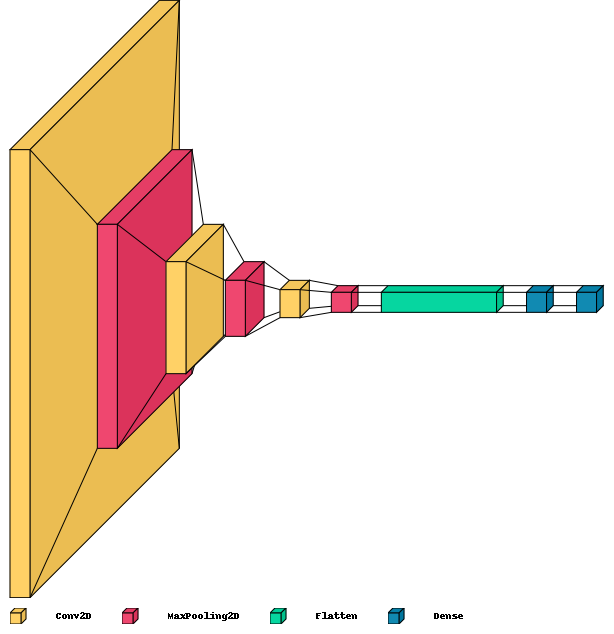

In [ ]:
visualkeras.layered_view(best_model, legend = True, spacing = 30)

L'immagine sopra riportata rappresenta idealmente la struttura del modello ottenuto dall'ottimizzatore. In particolare il tuner ha rilevato che l'inserimento di un ulteriore blocco convoluzionale (layer da $64$ filtri $3\times 3$) potesse migliorare le performance della rete. Inoltre la configurazione ottenuta ha modificato la struttura iniziale delle due convoluzioni, impostando il primo con $16$ filtri e il secondo con $128$ filtri lasciandone invariata la dimensione. Il numero di unità del penultimo strato è stato diminuito da $228$ a $64$. <br>
Il modello così ottenuto è riportato nell'immagine seguente; si è poi passati al suo nuovo addestramento.

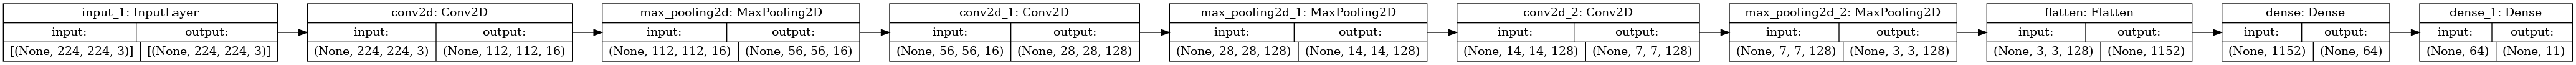

In [ ]:
tuned_model = tuner.hypermodel.build(best_hps)

# Visualizzazione modello Baseline tuned
keras.utils.plot_model(tuned_model, show_shapes = True, rankdir= 'LR')

L'addestramento del nuovo modello `tuned_model`, ottimizzato con <i>adam</i> con un learing rate pari a $0.0005$, è stato condotto per $50$ epoche mantendo l'utilizzo dell'early stopping con un `patience=3` e una variazione minima `min_delta=0.0015`.

In [ ]:
# Addestramento modello ottimizzato | 50 epoche con EarlyStopping
tuned_h, tuned_es = train_model(tuned_model, eps = 50,
                                early_stopping = True, pat = 3, min_d = 15e-4)

Epoch 1/50
49/49 [==============================] - 25s 434ms/step - loss: 7.6846 - accuracy: 0.1634 - recall: 0.0766 - val_loss: 2.3193 - val_accuracy: 0.2355 - val_recall: 0.0145
Epoch 2/50
49/49 [==============================] - 23s 408ms/step - loss: 2.5895 - accuracy: 0.2452 - recall: 0.0339 - val_loss: 2.1623 - val_accuracy: 0.2907 - val_recall: 0.1047
Epoch 3/50
49/49 [==============================] - 23s 417ms/step - loss: 2.3756 - accuracy: 0.3081 - recall: 0.0872 - val_loss: 2.0305 - val_accuracy: 0.3227 - val_recall: 0.1337
Epoch 4/50
49/49 [==============================] - 24s 434ms/step - loss: 2.2045 - accuracy: 0.3521 - recall: 0.1218 - val_loss: 1.9341 - val_accuracy: 0.3198 - val_recall: 0.1221
Epoch 5/50
49/49 [==============================] - 24s 419ms/step - loss: 1.9833 - accuracy: 0.4002 - recall: 0.1680 - val_loss: 1.9723 - val_accuracy: 0.3605 - val_recall: 0.2064
Epoch 6/50
49/49 [==============================] - 23s 413ms/step - loss: 1.7923 - accuracy: 0

Come per il modello precedente, l'Early Stopping ha interrotto l'addestramento della rete dopo $15$ epoche mantenendo come valore ottimo la configurazione ottenuta alla $12^\circ$ epoca. Tuttavia, nonostante le buone prestazioni ottenute sul training set, si riscontra dell'overfitting a partire dalla $5^\circ$ epoca. Nonostante questa problematica, si può osservare che le prestazioni dell'ultimo modello siano fin dalle prime epoche migliori rispetto alla rete `baseline`.

Informazioni utili: 

Numero di epoche totali: 15
Epoca migliore (weights restored): 12
Accuracy training set all'epoca 12: 0.764211893081665
Accuracy validation set all'epoca 12: 0.447674423456192
Loss training set all'epoca 12: 0.7885043025016785
Loss validation set all'epoca 12: 1.740633249282837





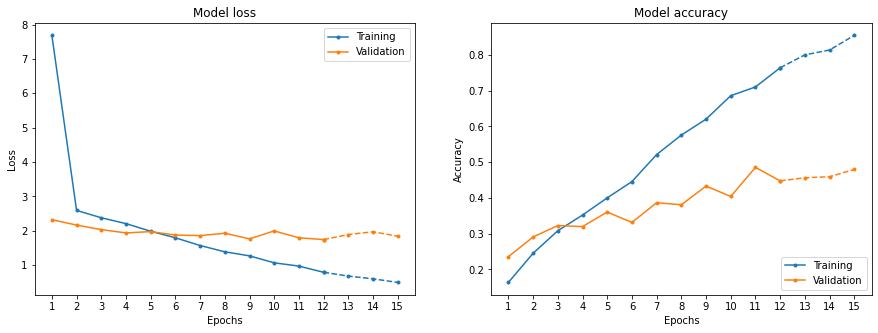

In [ ]:
plot_history(tuned_h, early_stop = tuned_es)

In [ ]:
tuned_pred = make_prediction(tuned_model, test_set)

In seguito alla classificazione svolta sul test set, si è proseguito con la valutazione dei risultati ottenuti. <br>
Osservando la seguente matrice di confusione, tenedo conto anche della [precedente](#cm_baseline), si nota come i valori sono concentrati maggiormente sulla diagonale principale, sinonimo di una migliore accuratezza di previsione. L'accuratezza ottenuta dalla rete è infatti pari al $49\%$ ed ha fatto registrare un incremento del $14\%$ rispetto allo stesso modello non ottimizzato. Questo netto miglioramento è osservabile ad esempio sulla classe `Edgar Degas`, che nell'attuale rete ha ottenuto una recall del $47\%$, nel modello precedente aveva una sensibilità pari al $19\%$ sulla medesima classe. <br>
Infatti le istanze della classe `Edgar Degas`, che nel modello `baseline` venivano assegnate maggiormente alla classe `Vincent van Gogh`, attraverso il modello ottimizzato vengono classificate erroneamente di meno.


Classification Report
                        precision    recall  f1-score   support

       Albrecht Dürer       0.68      0.67      0.67        66
        Alfred Sisley       0.49      0.46      0.48        52
          Edgar Degas       0.53      0.47      0.50       140
       Francisco Goya       0.51      0.50      0.50        58
         Marc Chagall       0.53      0.19      0.28        48
        Pablo Picasso       0.55      0.36      0.44        88
         Paul Gauguin       0.34      0.60      0.43        62
Pierre-Auguste Renoir       0.29      0.37      0.33        67
            Rembrandt       0.51      0.69      0.59        52
               Titian       0.48      0.27      0.35        51
     Vincent van Gogh       0.53      0.59      0.56       175

             accuracy                           0.49       859
            macro avg       0.49      0.47      0.47       859
         weighted avg       0.50      0.49      0.48       859



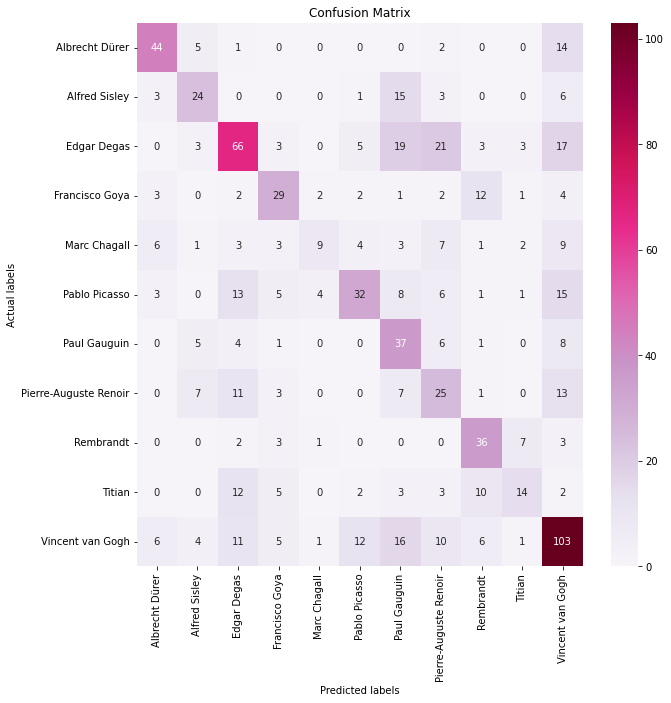

In [ ]:
evaluate_prediction(tuned_model, y_test, tuned_pred, labels, plot_size = (10,10))

In [ ]:
tuned_model.save(MODEL_PATH + 'baseline_tuned.h5')

## Fine Tuning
Uno degli approcci testati per la risoluzione del task è quello del **Fine Tuning** che consiste nell'utilizzo di CNN pre-addestrate su un task differente, ma opportunamente modificate. Per ogni CNN considerata sono stati testati due modelli, uno *base*, ovvero la CNN scelta con la concatenazione dei layer specifici per il task ed uno invece in cui è stato introdotta la **Data Augmentation**.


### <b> MobileNetV2 </b>
Il primo modello considerato è MobileNetV2, una rete leggera, pesa 14 MB,  adatta a funzionare bene anche su dispositivi mobili, dato che il numero di parametri di cui è costituita è minimo.
Quindi una volta importato il modello base, con i pesi usati per il task Imagenet, viene tagliato all'altezza dell'ultimo layer denso che verrà sostituito da alcuni layer specifici per il task.

In [ ]:
# Import MobileNetV2
base_model_mn = MobileNetV2(weights = 'imagenet')

Esclusione dell'ultimo layer denso
base_model_mn = Model(inputs = base_model_mn.input, 
                      outputs = base_model_mn.get_layer('global_average_pooling2d').output)

14548992/14536120 [==============================] - 0s 0us/step


Una volta tagliato il modello base, viene definita la funzione che permette di rendere il modello più specifico attraverso la concatenazione di alcuni layer, tra cui quello di Input a cui viene imposta una shape di $(224, 224, 3)$.

In [ ]:
def mobilenet_tuning(base_model, lr, augmentation = False): 
  """
  Funzione per il fine-tuning e la specificazione della rete MobileNetV2
  :param base_mode: modello base pre-addestrato
  :param float lr: valore del learning rate dell'ottimizzatore
  :param bool augmentation: True se si vuole effettuare Data Augmentation
  """
  # Reset sezione
  keras.backend.clear_session()
  keras.backend.reset_uids()
  
  # Freezing dei layer di MobileNetV2
  for layer in base_model.layers:
    layer.trainable = False
  
  # Input layer
  inputs = keras.Input(shape=INPUT_SHAPE)
  x = inputs

  # Data Augmentation
  if augmentation == True:
    x = keras.layers.RandomRotation(0.4, fill_mode = 'nearest')(x)
    x = keras.layers.RandomFlip('horizontal')(x) 
    x = keras.layers.RandomFlip('vertical')(x)
    x = keras.layers.RandomContrast(0.1)(x)
    x = keras.layers.RandomZoom(0.5)(x)

  # Preprocessing dei dati
  x = keras.applications.mobilenet_v2.preprocess_input(x)
  x = base_model(x)

  # Specificazione del modello
  x = keras.layers.Dense(128, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(64, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.3)(x)
  x = keras.layers.Dense(32, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.4)(x)
  x = keras.layers.Dense(NUM_CLASSES, activation = 'softmax')(x)

  # Modello finale
  outputs = x
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compilazione modello
  model.compile(optimizer = Adam(lr),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
  return model

In [ ]:
model_mn = mobilenet_tuning(base_model_mn, lr = 0.001) 
model_mn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model_1 (Functional)        (None, 1000)              3538984   
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dropout (Dropout)           (None, 128)               0     

In [ ]:
# Training
history_mn, early_stopping = train_model(model_mn, bs = 64, eps = 50, early_stopping = True, pat = 5)

Epoch 1/50
49/49 [==============================] - 33s 526ms/step - loss: 2.8335 - accuracy: 0.1902 - val_loss: 2.2920 - val_accuracy: 0.2122
Epoch 2/50
49/49 [==============================] - 31s 570ms/step - loss: 2.6620 - accuracy: 0.2032 - val_loss: 2.2251 - val_accuracy: 0.2122
Epoch 3/50
49/49 [==============================] - 29s 502ms/step - loss: 2.5334 - accuracy: 0.2064 - val_loss: 2.1228 - val_accuracy: 0.2122
Epoch 4/50
49/49 [==============================] - 28s 504ms/step - loss: 2.3466 - accuracy: 0.2691 - val_loss: 2.0140 - val_accuracy: 0.2791
Epoch 5/50
49/49 [==============================] - 28s 501ms/step - loss: 2.1909 - accuracy: 0.3220 - val_loss: 1.8819 - val_accuracy: 0.3430
Epoch 6/50
49/49 [==============================] - 29s 501ms/step - loss: 2.0574 - accuracy: 0.3663 - val_loss: 1.8492 - val_accuracy: 0.3372
Epoch 7/50
49/49 [==============================] - 28s 504ms/step - loss: 1.9812 - accuracy: 0.3821 - val_loss: 1.7518 - val_accuracy: 0.3837

Informazioni utili: 

Numero di epoche totali: 18
Epoca migliore (weights restored): 13
Accuracy training set all'epoca 13: 0.4945090413093567
Accuracy validation set all'epoca 13: 0.42151162028312683
Loss training set all'epoca 13: 1.5975019931793213
Loss validation set all'epoca 13: 1.6779391765594482





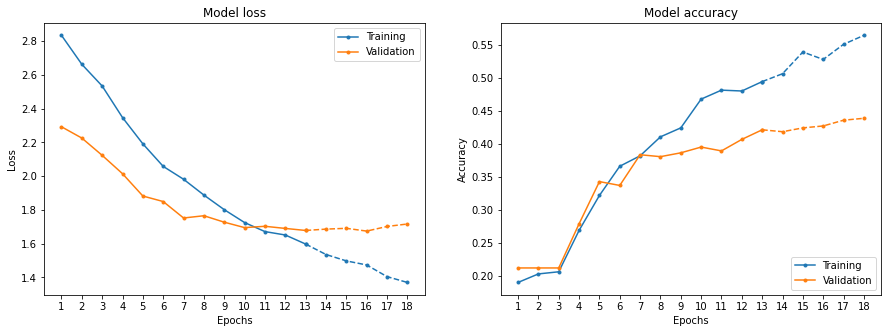

In [ ]:
plot_history(history_mn, early_stop = early_stopping)

E' evidente che il modello soffra pesantemente di overfitting, infatti già dalla decima epoca la curva di loss del validation diverge ampiamente da quella che training. La stessa cosa è osservabile dal plot dell'accuracy in cui la curva blu (training set) si separa da quella del validation. Tuttavia grazie all'Early Stopping l'addestramento è stato bloccato *in tempo*, in modo da non peggiorare ulteriormente.

In [ ]:
y_pred = make_prediction(model_mn, test_set)


Classification Report
                        precision    recall  f1-score   support

       Albrecht Dürer       0.87      0.20      0.32        66
        Alfred Sisley       0.74      0.38      0.51        52
          Edgar Degas       0.72      0.65      0.68       140
       Francisco Goya       0.38      0.48      0.43        58
         Marc Chagall       0.62      0.33      0.43        48
        Pablo Picasso       0.48      0.49      0.49        88
         Paul Gauguin       0.44      0.39      0.41        62
Pierre-Auguste Renoir       0.61      0.64      0.62        67
            Rembrandt       0.39      0.52      0.45        52
               Titian       0.41      0.51      0.46        51
     Vincent van Gogh       0.50      0.71      0.59       175

             accuracy                           0.53       859
            macro avg       0.56      0.48      0.49       859
         weighted avg       0.57      0.53      0.52       859



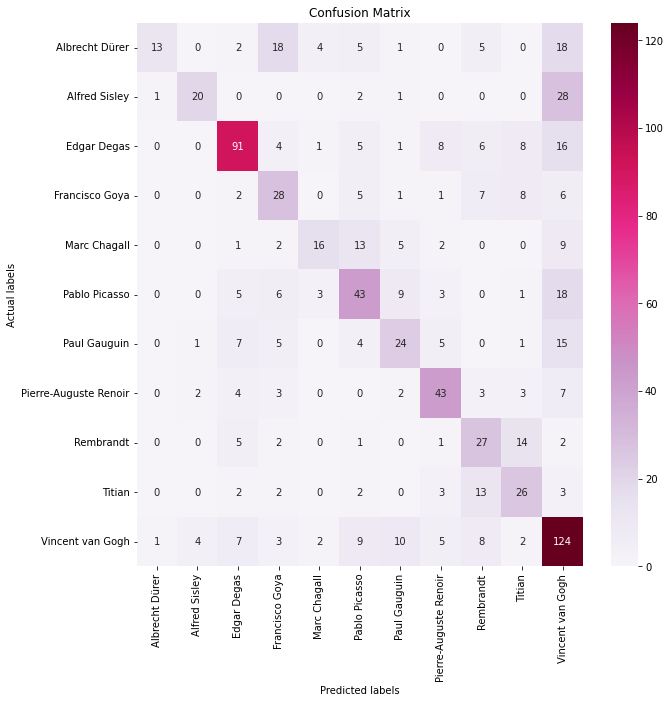

In [ ]:
evaluate_prediction(model_mn, y_test, y_pred, labels, plot_size=(10,10)) 

Il modello, vista la bassa accuratezza ottenuta, commette molti errori. In particolare le istanze della classe 'Albrecht Durer' vengono classificate erroneamente molte volte. Inoltre in molti casi la maggior parte delle istanze classificate male sono state assegnate alla classe 'Vincent Van Gogh', la classe col maggior numero di istanze. 

In [ ]:
model_mn.save(MODEL_PATH + 'mn.h5')

#### <b> MobileNetV2 </b> con Data Augmentation
Visto che l'addestramento del modello è soggetto all'overfitting, si è deciso di sperimentare la <b> Data Augmentation </b>. Si tratta di una tecnica che permette di aumentare la diversità e il volume dei dati di training. Questo viene fatto applicando diverse trasformazioni casuali, ma realistiche, ai dati, come la rotazione dell'immagine. In particolare sono stati testai i seguenti layer:
- RandomRotation;
- RandomFlip *orizzontale* e *verticale*;
- RandomContrast;
- RandomZoom;

Il modello implementato è lo stesso, la differenza consiste nell'aggiunta dei 4 layer descritti, subito dopo il layer di Input. Sono state testate diverse combinazioni dei layer e dei relativi parametri, quella presentata è quella che garantisce i risultati migliori.

In [ ]:
model_mn_aug = mobilenet_tuning(base_model_mn, lr = 0.001, augmentation = True)
model_mn_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0     

In [ ]:
# Addestramento
history_mn_aug, early_stopping_aug = train_model(model_mn_aug, bs = 64, eps = 50, early_stopping = True, pat = 5)

Epoch 1/50
49/49 [==============================] - 41s 682ms/step - loss: 2.8395 - accuracy: 0.1919 - val_loss: 2.3124 - val_accuracy: 0.2122
Epoch 2/50
49/49 [==============================] - 28s 502ms/step - loss: 2.6920 - accuracy: 0.2025 - val_loss: 2.2655 - val_accuracy: 0.2122
Epoch 3/50
49/49 [==============================] - 30s 540ms/step - loss: 2.5923 - accuracy: 0.2051 - val_loss: 2.2077 - val_accuracy: 0.2122
Epoch 4/50
49/49 [==============================] - 28s 503ms/step - loss: 2.4916 - accuracy: 0.2326 - val_loss: 2.1761 - val_accuracy: 0.2645
Epoch 5/50
49/49 [==============================] - 28s 501ms/step - loss: 2.4006 - accuracy: 0.2661 - val_loss: 2.1466 - val_accuracy: 0.2820
Epoch 6/50
49/49 [==============================] - 28s 507ms/step - loss: 2.3172 - accuracy: 0.2926 - val_loss: 2.0577 - val_accuracy: 0.3198
Epoch 7/50
49/49 [==============================] - 28s 500ms/step - loss: 2.2255 - accuracy: 0.3140 - val_loss: 2.0273 - val_accuracy: 0.2936

Informazioni utili: 

Numero di epoche totali: 34
Epoca migliore (weights restored): 29
Accuracy training set all'epoca 29: 0.46802327036857605
Accuracy validation set all'epoca 29: 0.39534884691238403
Loss training set all'epoca 29: 1.6944565773010254
Loss validation set all'epoca 29: 1.7895557880401611





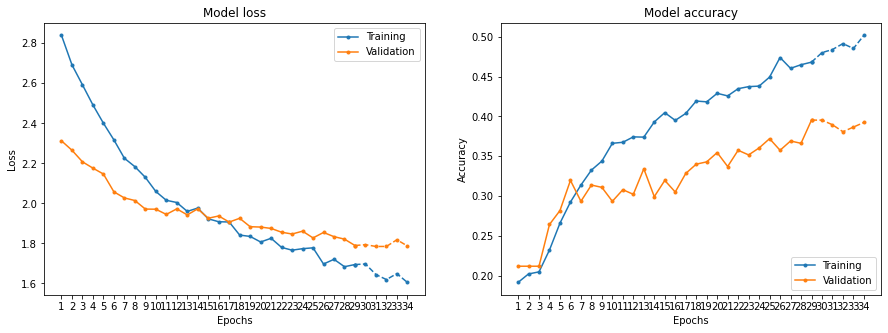

In [ ]:
plot_history(history_mn_aug, early_stop = early_stopping_aug)

Rispetto al modello precedente, l'addestramento soffre meno di overfitting ma non nel modo sperato. Unito al fatto che l'accuratezza è notevolmente peggiorata non ci riteniamo soddisfatti dei risultati.

In [ ]:
y_pred = make_prediction(model_mn_aug, test_set)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report
                        precision    recall  f1-score   support

       Albrecht Dürer       0.65      0.23      0.34        66
        Alfred Sisley       0.00      0.00      0.00        52
          Edgar Degas       0.66      0.44      0.53       140
       Francisco Goya       0.44      0.41      0.42        58
         Marc Chagall       0.27      0.17      0.21        48
        Pablo Picasso       0.46      0.41      0.43        88
         Paul Gauguin       0.33      0.44      0.38        62
Pierre-Auguste Renoir       0.47      0.51      0.49        67
            Rembrandt       0.43      0.56      0.49        52
               Titian       0.42      0.53      0.47        51
     Vincent van Gogh       0.39      0.66      0.49       175

             accuracy                           0.44       859
            macro avg       0.41      0.40      0.39       859
         weighted avg       0.44      0.44      0.42       859



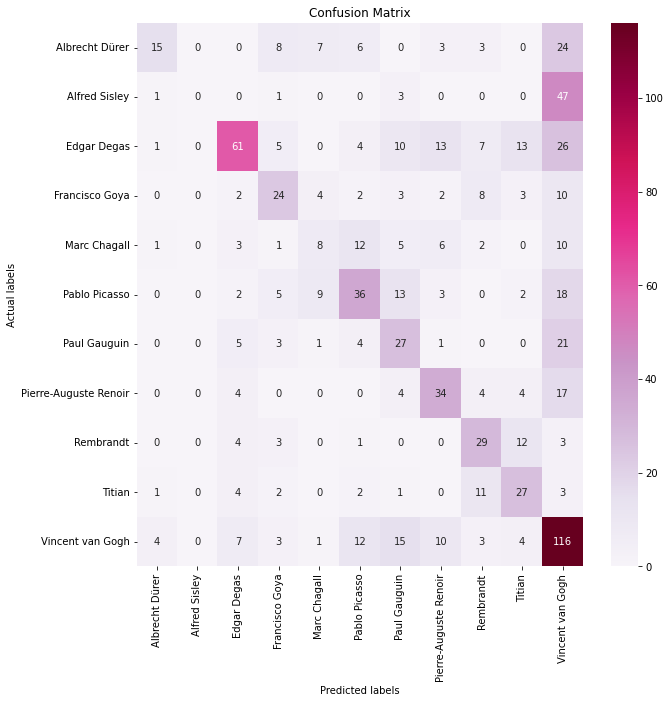

In [ ]:
evaluate_prediction(model_mn_aug, y_test, y_pred, labels, plot_size=(10,10)) 

Il modello, come previsto, commette molti più errori, anche per la classe 'Vincent Van Gogh' che è quella con più elementi. Nonostante varie combinazioni dei layer di Data Augmentation e dei loro parametri, questo è stato il risultato migliore che è stato possibile ottenere. 

In [ ]:
model_mn_aug.save(MODEL_PATH + 'mn_aug.h5')

### <b> VGG-16 </b>
Il secondo modello sperimentato è <b> VGG-16 </b>, una CNN proposta dal Visual Geometry Group dell’Università di Oxford durante la ImageNet Large Scale Visual Recognition Challenge. Si tratta di un modello più pesante e con più parametri rispetto a MobileNetV2. Una volta privato degli ultimi layer densi, il modello è stato concatenato a dei layer più specifici.


In [ ]:
base_model_vgg = VGG16(weights = 'imagenet')
# Esclusione layer densi dal modello 
base_model_vgg = Model(inputs = base_model_vgg.input, 
                      outputs = base_model_vgg.get_layer('flatten').output)

553476096/553467096 [==============================] - 4s 0us/step


In [ ]:
def vgg_tuning(base_model, lr, augmentation = False):
  """
  Funzione per il fine-tuning e la specificazione della rete VGG-16
  :param base_mode: modello base pre-addestrato
  :param float lr: valore del learning rate dell'ottimizzatore
  :param bool augmentation: True se si vuole effettuare Data Augmentation
  """
  keras.backend.clear_session()
  keras.backend.reset_uids()

  for layer in base_model.layers:
    layer.trainable = False
  
  # Input layer
  inputs = keras.Input(shape=(224,224,3))
  x = inputs

  # Data Augmentation
  if augmentation == True:
    x = keras.layers.RandomRotation(0.4, fill_mode = 'nearest')(x)
    x = keras.layers.RandomFlip('horizontal')(x) 
    x = keras.layers.RandomFlip('vertical')(x)
    x = keras.layers.RandomContrast(0.1)(x)

  # Preprocessing e concatenazione col modello base
  x = keras.applications.vgg16.preprocess_input(x)
  x = base_model(x)

  # Specificazione del modello
  x = keras.layers.Dense(512, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(256, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(64, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.3)(x)
  outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

  # Modello finale
  model= keras.Model(inputs=inputs, outputs=outputs)

  model.compile(optimizer=Adam(lr),
                    loss='categorical_crossentropy',
                    metrics = ['accuracy'])
  return model

In [ ]:
model_vgg = vgg_tuning(base_model_vgg, lr = 0.001)
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 model (Functional)          (None, 25088)             14714688  
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
# Addestramento
history_vgg, early_stopping_vgg = train_model(model_vgg, bs = 64, eps = 50, early_stopping = True, pat = 5)

Epoch 1/50
49/49 [==============================] - 431s 7s/step - loss: 8.0044 - accuracy: 0.1741 - val_loss: 2.2720 - val_accuracy: 0.2151
Epoch 2/50
49/49 [==============================] - 38s 687ms/step - loss: 2.8926 - accuracy: 0.2119 - val_loss: 2.1646 - val_accuracy: 0.2238
Epoch 3/50
49/49 [==============================] - 37s 684ms/step - loss: 2.8518 - accuracy: 0.2222 - val_loss: 2.2649 - val_accuracy: 0.2093
Epoch 4/50
49/49 [==============================] - 37s 682ms/step - loss: 2.5657 - accuracy: 0.2348 - val_loss: 2.0383 - val_accuracy: 0.2645
Epoch 5/50
49/49 [==============================] - 37s 682ms/step - loss: 2.3828 - accuracy: 0.2849 - val_loss: 1.9130 - val_accuracy: 0.3052
Epoch 6/50
49/49 [==============================] - 37s 682ms/step - loss: 2.3344 - accuracy: 0.2943 - val_loss: 1.9354 - val_accuracy: 0.3081
Epoch 7/50
49/49 [==============================] - 37s 683ms/step - loss: 2.2387 - accuracy: 0.3301 - val_loss: 1.8532 - val_accuracy: 0.3895
E

Informazioni utili: 

Numero di epoche totali: 20
Epoca migliore (weights restored): 15
Accuracy training set all'epoca 15: 0.6056201457977295
Accuracy validation set all'epoca 15: 0.6133720874786377
Loss training set all'epoca 15: 1.361271858215332
Loss validation set all'epoca 15: 1.437110424041748





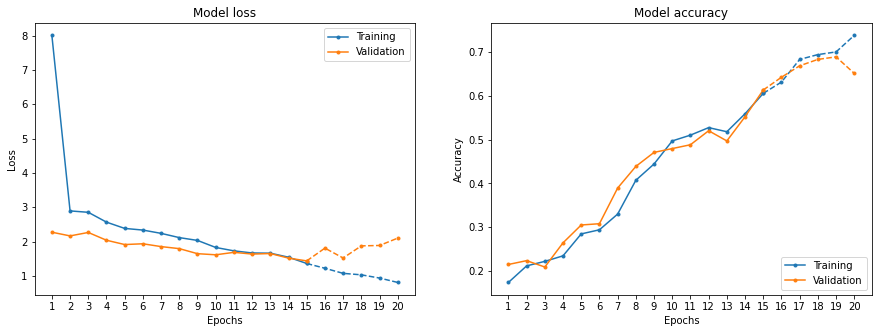

In [ ]:
plot_history(history_vgg,early_stop = early_stopping_vgg)

In [ ]:
y_pred_vgg = make_prediction(model_vgg, test_set)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report
                        precision    recall  f1-score   support

       Albrecht Dürer       0.00      0.00      0.00        66
        Alfred Sisley       0.83      0.77      0.80        52
          Edgar Degas       0.42      0.84      0.56       140
       Francisco Goya       1.00      0.45      0.62        58
         Marc Chagall       0.50      0.60      0.55        48
        Pablo Picasso       0.69      0.43      0.53        88
         Paul Gauguin       0.51      0.40      0.45        62
Pierre-Auguste Renoir       0.88      0.64      0.74        67
            Rembrandt       1.00      0.35      0.51        52
               Titian       0.42      0.84      0.56        51
     Vincent van Gogh       0.76      0.75      0.76       175

             accuracy                           0.60       859
            macro avg       0.64      0.55      0.55       859
         weighted avg       0.63      0.60      0.58       859



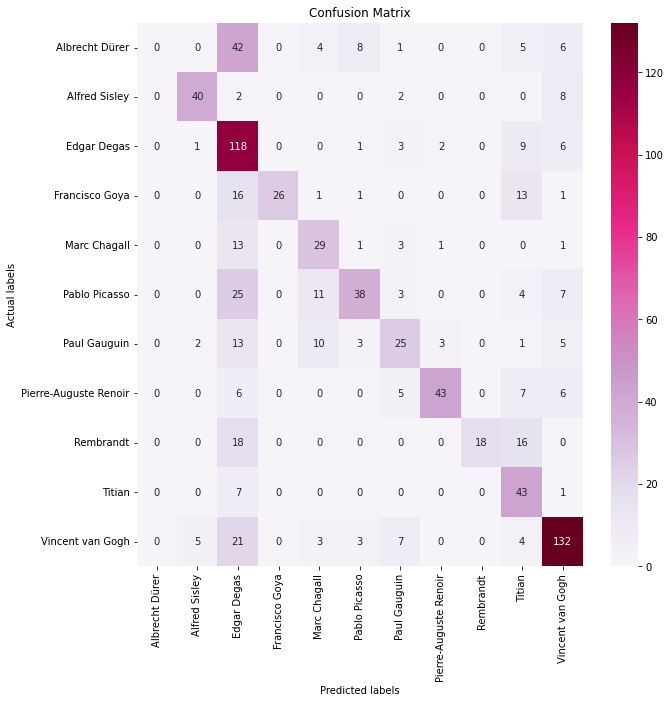

In [ ]:
evaluate_prediction(model_vgg, y_test, y_pred_vgg, labels, plot_size=(10,10)) 

#### VGG16 con Data Augmentation
Visto l'overfitting a cui sono andati incontro i modelli precedenti, abbiamo pensato che la *data augmentation* potesse essere una soluzione. Questa volta dai layer di Data Augmentation presentati prima, abbiamo escluso il RandomZoom in quanto peggiorava notevolmente i risultati, senza portare nessun beneficio.

In [ ]:
model_vgg_aug = vgg_tuning(base_model_vgg, lr = 0.01, augmentation = True)
model_vgg_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0     

In [ ]:
# Addestramento
history_vgg_aug, early_stopping_vgg_aug = train_model(model_vgg_aug,
                                                      bs = 64,
                                                      eps = 50,
                                                      early_stopping = True, 
                                                      pat = 5)

Epoch 1/50
49/49 [==============================] - 40s 708ms/step - loss: 7.6089 - accuracy: 0.1670 - val_loss: 2.3891 - val_accuracy: 0.2122
Epoch 2/50
49/49 [==============================] - 38s 698ms/step - loss: 2.9672 - accuracy: 0.1999 - val_loss: 2.3716 - val_accuracy: 0.2151
Epoch 3/50
49/49 [==============================] - 38s 696ms/step - loss: 2.8892 - accuracy: 0.2070 - val_loss: 2.3571 - val_accuracy: 0.2151
Epoch 4/50
49/49 [==============================] - 38s 698ms/step - loss: 2.8444 - accuracy: 0.2106 - val_loss: 2.3376 - val_accuracy: 0.2238
Epoch 5/50
49/49 [==============================] - 38s 694ms/step - loss: 2.8332 - accuracy: 0.2103 - val_loss: 2.3330 - val_accuracy: 0.2267
Epoch 6/50
49/49 [==============================] - 38s 696ms/step - loss: 2.7894 - accuracy: 0.2129 - val_loss: 2.2157 - val_accuracy: 0.2238
Epoch 7/50
49/49 [==============================] - 38s 693ms/step - loss: 2.7819 - accuracy: 0.2122 - val_loss: 2.3109 - val_accuracy: 0.2238

Informazioni utili: 

Numero di epoche totali: 18
Epoca migliore (weights restored): 13
Accuracy training set all'epoca 13: 0.21124030649662018
Accuracy validation set all'epoca 13: 0.223837211728096
Loss training set all'epoca 13: 2.558483362197876
Loss validation set all'epoca 13: 2.058016061782837





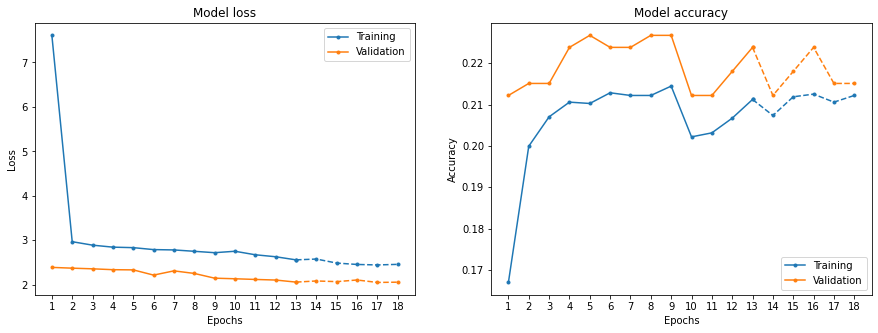

In [ ]:
plot_history(history_vgg_aug, early_stop = early_stopping_vgg_aug)

Nonostante la  Data Augmentation il modello non sembra beneficiare di alcun miglioramento: durante l'addestramento è emersa una situazione di **underfitting** che prima non era presente. Inoltre l'accuracy non segue un andamento fluido, ma ci sono numerosi picchi, dovuti forse ad un valore del learning rate troppo alto.

In [ ]:
y_pred_vgg_aug = make_prediction(model_vgg_aug, test_set)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report
                        precision    recall  f1-score   support

       Albrecht Dürer       0.00      0.00      0.00        66
        Alfred Sisley       0.00      0.00      0.00        52
          Edgar Degas       0.00      0.00      0.00       140
       Francisco Goya       0.00      0.00      0.00        58
         Marc Chagall       0.00      0.00      0.00        48
        Pablo Picasso       0.00      0.00      0.00        88
         Paul Gauguin       0.00      0.00      0.00        62
Pierre-Auguste Renoir       0.00      0.00      0.00        67
            Rembrandt       0.80      0.15      0.26        52
               Titian       0.00      0.00      0.00        51
     Vincent van Gogh       0.21      1.00      0.34       175

             accuracy                           0.21       859
            macro avg       0.09      0.10      0.05       859
         weighted avg       0.09      0.21      0.09       859



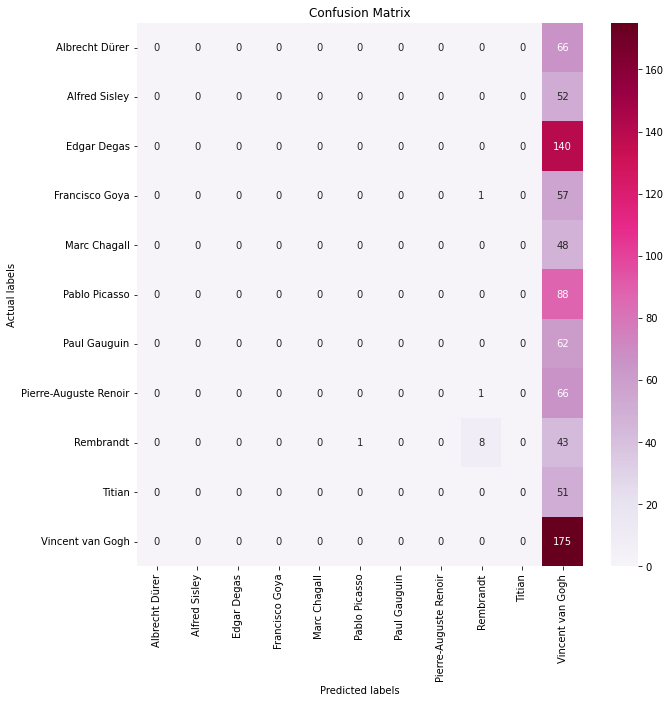

In [ ]:
evaluate_prediction(model_vgg_aug, y_test, y_pred_vgg_aug, labels, plot_size=(10,10)) 

I risultati ottenuti sono tra i peggiori ottenuti, l'accuratezza è peggiorata moltissimo, vale $0.21$. Inoltre la quasi totalità delle istanze è state assegnata alla classe 'Vincent Van Gogh'.

In [ ]:
model_vgg_aug.save(MODEL_PATH + 'vgg_aug.h5')

### <b> ResNet-50 </b>
L'ultimo modello sperimentato è infine ResNet50, il modello con più parametri. Una volta tagliato l'ultimo layer denso, la rete è stata concatenata a dei layer più specifici per il task.

In [ ]:
base_model_rn50 = ResNet50(weights='imagenet')

base_model_rn50 = Model(inputs=base_model_rn50.input, 
                    outputs=base_model_rn50.get_layer('avg_pool ').output)

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
base_model_rn50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
def resnet_tuning(base_model, lr, augmentation = False): 
  """
  Funzione per il fine-tuning e la specificazione della rete ResNet-50
  :param base_mode: modello base pre-addestrato
  :param float lr: valore del learning rate dell'ottimizzatore
  :param bool augmentation: True se si vuole effettuare Data Augmentation 
  """
  # Reset sezione
  keras.backend.clear_session()
  keras.backend.reset_uids()
  
  # Freezing dei layer di ResNet50
  for layer in base_model.layers:
    layer.trainable = False
  
  # Input layer
  inputs = keras.Input(shape=(224,224,3))
  x = inputs

  # Data Augmentation
  if augmentation == True:
    x = keras.layers.RandomFlip('horizontal')(x) 
    x = keras.layers.RandomFlip('vertical')(x)
    x = keras.layers.RandomRotation(0.4, fill_mode = 'nearest')(x)
    x = keras.layers.RandomContrast(0.1)(x)
    x = keras.layers.RandomZoom(0.5)(x)

  # Preprocessing dei dati
  x = keras.applications.resnet50.preprocess_input(x)
  x = base_model(x)

  # Specificazione del modello
  x = keras.layers.Dense(512, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.3)(x) 
  x = keras.layers.Dense(256, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(64, activation = 'relu')(x) 
  x = keras.layers.Dropout(0.1)(x)
  x = keras.layers.Dense(num_classes, activation = 'softmax')(x)

  # Modello finale
  outputs = x
  model = keras.Model(inputs=inputs, outputs=outputs)

  # Compilazione modello
  model.compile(optimizer = Adam(lr),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
  return model

In [ ]:
model_rn = resnet_tuning(base_model_rn50, lr = 0.001)
model_rn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 model (Functional)          (None, 1000)              25636712  
                                                                 
 dense (Dense)               (None, 512)               512512    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
# Trainining
history_rn, early_stop_rn = train_model(model_rn, bs = 64, eps = 50, early_stopping = True, pat = 3)

Epoch 1/50
49/49 [==============================] - 39s 622ms/step - loss: 2.7000 - accuracy: 0.1986 - val_loss: 2.1965 - val_accuracy: 0.2122
Epoch 2/50
49/49 [==============================] - 33s 592ms/step - loss: 2.3321 - accuracy: 0.2820 - val_loss: 1.9098 - val_accuracy: 0.3634
Epoch 3/50
49/49 [==============================] - 33s 588ms/step - loss: 1.9740 - accuracy: 0.3950 - val_loss: 1.7492 - val_accuracy: 0.3663
Epoch 4/50
49/49 [==============================] - 33s 592ms/step - loss: 1.7510 - accuracy: 0.4428 - val_loss: 1.6696 - val_accuracy: 0.4070
Epoch 5/50
49/49 [==============================] - 33s 595ms/step - loss: 1.5936 - accuracy: 0.4884 - val_loss: 1.6393 - val_accuracy: 0.4302
Epoch 6/50
49/49 [==============================] - 32s 585ms/step - loss: 1.4971 - accuracy: 0.5268 - val_loss: 1.6303 - val_accuracy: 0.4244
Epoch 7/50
49/49 [==============================] - 33s 590ms/step - loss: 1.3857 - accuracy: 0.5536 - val_loss: 1.6769 - val_accuracy: 0.4244

Informazioni utili: 

Numero di epoche totali: 8
Epoca migliore (weights restored): 5
Accuracy training set all'epoca 5: 0.4883720874786377
Accuracy validation set all'epoca 5: 0.43023255467414856
Loss training set all'epoca 5: 1.593588948249817
Loss validation set all'epoca 5: 1.6392710208892822





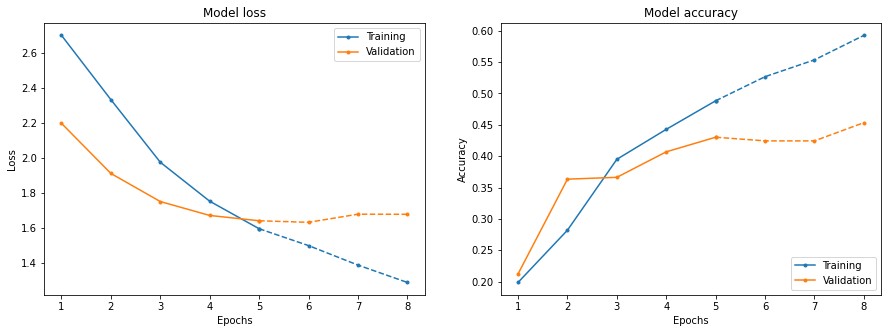

In [ ]:
plot_history(history_rn, early_stop = early_stop_rn)

Come per tutti i casi precedenti, il modello soffre di overfitting, ma l'Early Stopping ha impedito che le performance peggiorassero ulteriormente, stoppando l'addestramento alla quinta epoca.

In [ ]:
y_pred_rn = make_prediction(model_rn, test_set)


Classification Report
                        precision    recall  f1-score   support

       Albrecht Dürer       1.00      0.03      0.06        66
        Alfred Sisley       0.59      0.19      0.29        52
          Edgar Degas       0.54      0.45      0.49       140
       Francisco Goya       0.44      0.33      0.38        58
         Marc Chagall       0.75      0.06      0.12        48
        Pablo Picasso       0.32      0.41      0.36        88
         Paul Gauguin       0.37      0.29      0.32        62
Pierre-Auguste Renoir       0.37      0.42      0.39        67
            Rembrandt       0.49      0.67      0.56        52
               Titian       0.39      0.41      0.40        51
     Vincent van Gogh       0.40      0.73      0.52       175

             accuracy                           0.42       859
            macro avg       0.52      0.36      0.35       859
         weighted avg       0.50      0.42      0.39       859



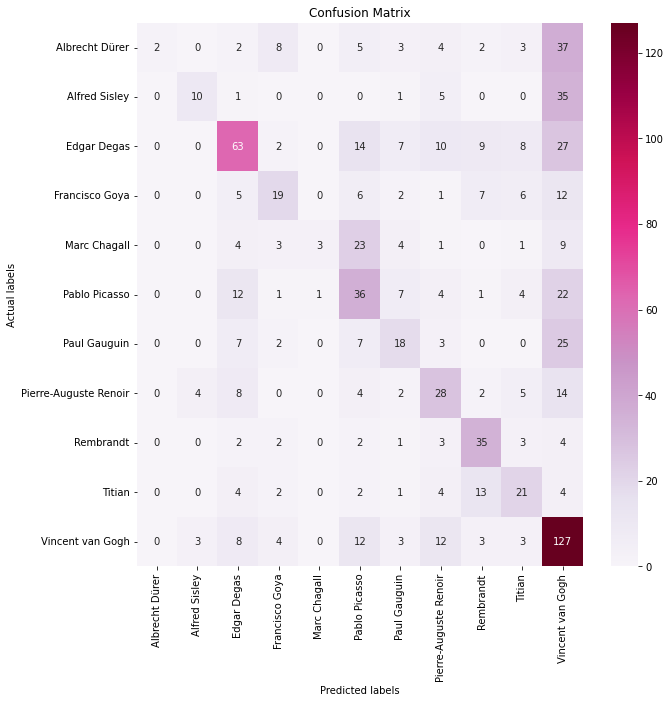

In [ ]:
evaluate_prediction(model_rn, y_test, y_pred_rn, labels, plot_size=(10,10)) 

I risultati ottenuti sono simili a quelli di MobileNetV2, infatti anche in questo caso gli errori sono molti e la classe 'Vincent Van Gogh' è quella a cui vengono assegnate più istanze.

In [ ]:
model_rn.save(MODEL_PATH + 'rn.h5')

#### ResNet con Data Augmentation
I layer utilizzati sono ancora una volta quelli presentati nel paragrafo MobileNetV2.

In [ ]:
model_rn_aug = resnet_tuning(base_model_rn50, lr = 0.001, augmentation = True)
model_rn_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0     

In [ ]:
# Addestramento
history_rn_aug, early_stop_aug = train_model(model_rn_aug, bs = 64, eps = 50, 
                                            early_stopping = True, pat = 3)

Epoch 1/50
49/49 [==============================] - 42s 679ms/step - loss: 2.7300 - accuracy: 0.1999 - val_loss: 2.3063 - val_accuracy: 0.2122
Epoch 2/50
49/49 [==============================] - 33s 597ms/step - loss: 2.5638 - accuracy: 0.2022 - val_loss: 2.1824 - val_accuracy: 0.2180
Epoch 3/50
49/49 [==============================] - 33s 597ms/step - loss: 2.3260 - accuracy: 0.2678 - val_loss: 1.9898 - val_accuracy: 0.2791
Epoch 4/50
49/49 [==============================] - 34s 606ms/step - loss: 2.1716 - accuracy: 0.3246 - val_loss: 1.9990 - val_accuracy: 0.2733
Epoch 5/50
49/49 [==============================] - 33s 603ms/step - loss: 2.0603 - accuracy: 0.3608 - val_loss: 1.9212 - val_accuracy: 0.3169
Epoch 6/50
49/49 [==============================] - 36s 655ms/step - loss: 2.0190 - accuracy: 0.3666 - val_loss: 1.9531 - val_accuracy: 0.2994
Epoch 7/50
49/49 [==============================] - 45s 805ms/step - loss: 1.9244 - accuracy: 0.3995 - val_loss: 1.8646 - val_accuracy: 0.3517

Informazioni utili: 

Numero di epoche totali: 10
Epoca migliore (weights restored): 7
Accuracy training set all'epoca 7: 0.399547815322876
Accuracy validation set all'epoca 7: 0.3517441749572754
Loss training set all'epoca 7: 1.9243676662445068
Loss validation set all'epoca 7: 1.864631175994873





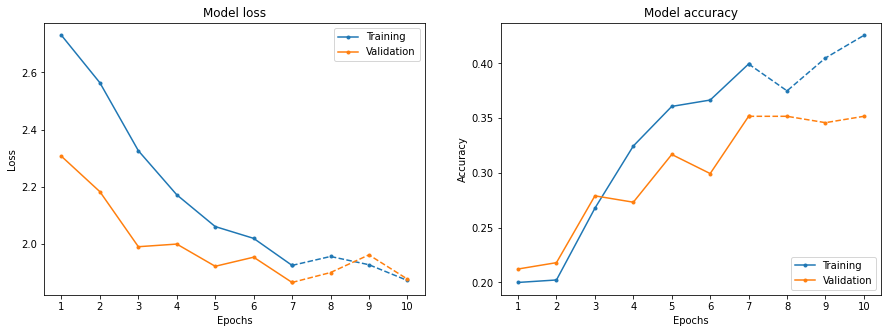

In [ ]:
plot_history(history_rn_aug, early_stop = early_stop_aug)

Come si può notare l'Early Stopping ha bloccato l'addestramento alla settima epoca. Rispetto a VGG-16 i risultati sono più apprezzabili, è vero che l'accuratezza è scesa, ma l'overfitting è in parte diminuito.

In [ ]:
y_pred_rn_aug = make_prediction(model_rn_aug, test_set)


Classification Report
                        precision    recall  f1-score   support

       Albrecht Dürer       1.00      0.14      0.24        66
        Alfred Sisley       0.50      0.19      0.28        52
          Edgar Degas       0.45      0.24      0.31       140
       Francisco Goya       0.22      0.10      0.14        58
         Marc Chagall       0.13      0.04      0.06        48
        Pablo Picasso       0.35      0.31      0.33        88
         Paul Gauguin       0.23      0.39      0.29        62
Pierre-Auguste Renoir       0.28      0.27      0.27        67
            Rembrandt       0.52      0.31      0.39        52
               Titian       0.27      0.49      0.35        51
     Vincent van Gogh       0.33      0.65      0.44       175

             accuracy                           0.33       859
            macro avg       0.39      0.28      0.28       859
         weighted avg       0.39      0.33      0.31       859



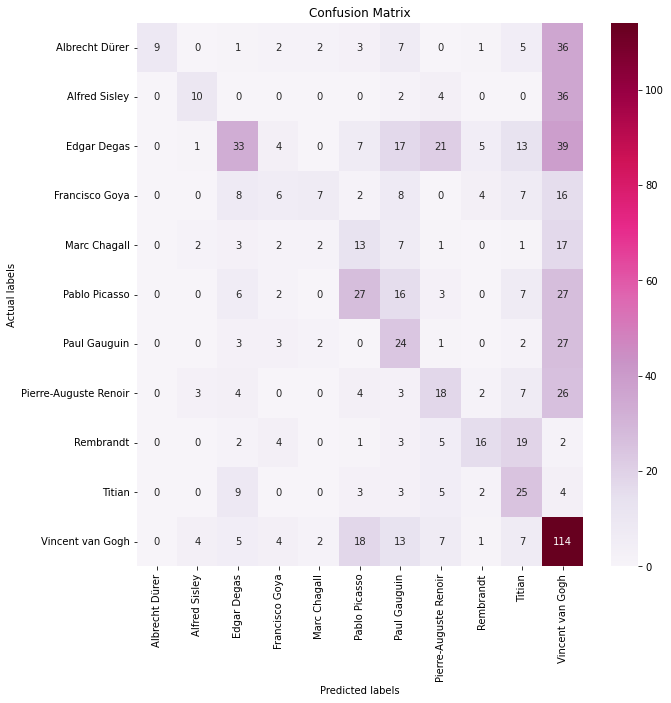

In [ ]:
evaluate_prediction(model_rn_aug, y_test, y_pred_rn_aug, labels, plot_size=(10,10)) 

Il modello commette molti errori, ma inaspettatamente riesce a classificare meglio le istanze di 'Albrecth Durer', infatti vengono classificate correttamente 9 volte volte, rispetto alle 2 del modello precedente.

In [ ]:
model_rn_aug.save(MODEL_PATH + 'rn_aug.h5')

## Ottimizzazione Iper-parametri
Gli iper-parametri utilizzati nei modelli sono stati fissati dopo una serie di prove manuali. Vogliamo quindi sperimentare un approccio più formale per selezionare i parametri migliori per la rete al fine di migliorare le performance dei modelli. Abbiamo deciso di effettuare l'operazione di ottimizzazione solo sul modello VGG16, in quanto è quello che ha ottenuto i risultati migliori e che sono, a nostro avviso, ulteriormente migliorabili.

La seguenze funzione contiene il modello che andrà ottimizzato, la struttura è la stessa del modello VGG-16 precedente, ma tutti i parametri sono liberi di variare all'interno di un range prefissato o tra una lista di valori candidati, come è possibile vedere dalla tabella sotto.
<figure>
<center><img src="https://drive.google.com/uc?id=1d6XdaDhzr9TODm0GIrSphC5cJNgmfOwK" alt="Benchmark DNN" width="500" height="300">
<figcaption><b>Fig.2</b> - Spazio di ricerca per il modello <i>VGG-16</i>;</figcaption></center>
</figure>

In [ ]:
def build_vgg(hp):
  # DEFINIZIONE IPERPARAMETRI
  drop_rate = [0.0, 0.1, 0.2, 0.3]
  opt_functions = ['Adam', 'SGD', 'rmsprop']

  # Input Layer
  inputs = keras.Input(shape = (224,224,3))
  x = inputs
  # Data Augmentation
  hp_flip = hp.Boolean('random_flip', default=False)
  if hp_flip:
    x = keras.layers.RandomFlip(mode = 'horizontal_and_vertical')(x)

  hp_rotation = hp.Float('random_rotation', min_value=0.0, max_value=0.5, step=0.05)
  x = keras.layers.RandomRotation(factor =  hp_rotation)(x)

  hp_contrast = hp.Float('random_constrast', min_value=0.0, max_value=0.5, step=0.1)
  if hp_contrast != 0:
    x = keras.layers.RandomContrast(factor = hp_contrast)(x)

  x = keras.applications.vgg16.preprocess_input(x)
  x = base_model_vgg(x)

  # Specificazione del modello
  initializer = keras.initializers.GlorotUniform(seed=42)

  # Tuning del numero di neuroni per i layer fully connected
  hp_dense = hp.Int('dense_0', min_value= 128, max_value = 512, step = 64)
  x = keras.layers.Dense(hp_dense, activation = 'relu', kernel_initializer=initializer)(x)
  hp_drop = hp.Choice('dropout_0', values = drop_rate)
  x = keras.layers.Dropout(hp_drop)(x)
  hp_dense1 = hp.Int('dense_1', min_value = 64, max_value = 256, step = 32)
  x = keras.layers.Dense(hp_dense1, activation = 'relu', kernel_initializer=initializer)(x)
  hp_drop1 = hp.Choice('dropout_1', values=drop_rate)
  x = keras.layers.Dropout(hp_drop1)(x)
  hp_dense2 = hp.Int('dense_2', min_value = 32, max_value = 128, step = 16)
  x = keras.layers.Dense(hp_dense2, activation = 'relu', kernel_initializer=initializer)(x)
  
  # Output layer
  x = keras.layers.Dense(num_classes, activation = 'softmax')(x)
  outputs = x

  model = keras.Model(inputs = inputs, outputs = outputs)

  # Selezione funzione di ottimizzazione
  hp_optimizer = hp.Choice('optimizer', values = opt_functions, default = 'Adam')
  opt = keras.optimizers.get(hp_optimizer)
  # Selezione learning rate
  opt.learning_rate = hp.Float('lr', min_value = 1e-4, max_value = 1e-2,
                                 sampling = 'log')
  model.compile(optimizer = opt,
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Si utilizza l'ottimizzazione Bayeasiana per ottimizzare il modello, visto l'elevato numero di casistiche. L'obiettivo dell'ottimizzazione è quello di ridurre il valore di loss sul validation set, come si può notare dal parametro `objective`.

#### Ottimizzazione sulla Loss

In [ ]:
tuner = kt.BayesianOptimization(build_vgg,
                                objective = 'val_loss',
                                directory = './tuner',
                                max_trials = 25, overwrite = False,
                                project_name='vgg_tuning')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience = 3, min_delta = 0.001, 
                           verbose=1, restore_best_weights = True) 
tuner.search(train_set, epochs = 25, validation_data = val_set,
             shuffle = True, callbacks = [early_stop])

Trial 25 Complete [00h 15m 28s]
val_loss: 2.2769341468811035

Best val_loss So Far: 1.806297779083252
Total elapsed time: 05h 16m 15s


In [ ]:
# Parametri ottimali
best_param = tuner.get_best_hyperparameters()[0]

print('Best parameter VGG-16: ')
best_param.values

Best parameter VGG-16: 


{'random_flip': True,
 'random_rotation': 0.5,
 'random_constrast': 0.1,
 'dense_0': 320,
 'dropout_0': 0.0,
 'dense_1': 160,
 'dropout_1': 0.2,
 'dense_2': 64,
 'optimizer': 'Adam',
 'lr': 0.0017825900024172885}

Il modello così ottenuto è diverso da quello implementato manualmente, infatti riesce a performare molto meglio rispetto al nostro con Data Augmentation; per cui ci riteniamo soddisfatti dei risultati.

In [ ]:
vgg_tuned = tuner.hypermodel.build(best_param)
vgg_tuned.save(MODEL_PATH + 'vgg_optimized_loss.h5')

Addestriamo il modello VGG-16 con la miglior configurazione dei parametri trovata.

In [ ]:
history, e_s = train_model(vgg_tuned, bs = 128, eps = 50, early_stopping = True, pat = 3)

Epoch 1/50
49/49 [==============================] - 742s 13s/step - loss: 9.8979 - accuracy: 0.2293 - val_loss: 2.4685 - val_accuracy: 0.3081
Epoch 2/50
49/49 [==============================] - 37s 669ms/step - loss: 2.4241 - accuracy: 0.3446 - val_loss: 1.9641 - val_accuracy: 0.3576
Epoch 3/50
49/49 [==============================] - 37s 670ms/step - loss: 2.0164 - accuracy: 0.4118 - val_loss: 1.5420 - val_accuracy: 0.4913
Epoch 4/50
49/49 [==============================] - 37s 669ms/step - loss: 1.7675 - accuracy: 0.4677 - val_loss: 1.5189 - val_accuracy: 0.4971
Epoch 5/50
49/49 [==============================] - 37s 669ms/step - loss: 1.6520 - accuracy: 0.5155 - val_loss: 1.4539 - val_accuracy: 0.4709
Epoch 6/50
49/49 [==============================] - 37s 668ms/step - loss: 1.5315 - accuracy: 0.5420 - val_loss: 1.5366 - val_accuracy: 0.5087
Epoch 7/50
49/49 [==============================] - 37s 669ms/step - loss: 1.4809 - accuracy: 0.5620 - val_loss: 1.4528 - val_accuracy: 0.5552


Osservando i valori di `val_loss`, questi sono addirittura più bassi di quelli ottenuti durante il tuning, motivo per cui ci riteniamo molto soddisfatti.

Informazioni utili: 

Numero di epoche totali: 21
Epoca migliore (weights restored): 16
Accuracy training set all'epoca 16: 0.6996123790740967
Accuracy validation set all'epoca 16: 0.694767415523529
Loss training set all'epoca 16: 1.013421893119812
Loss validation set all'epoca 16: 1.0297012329101562





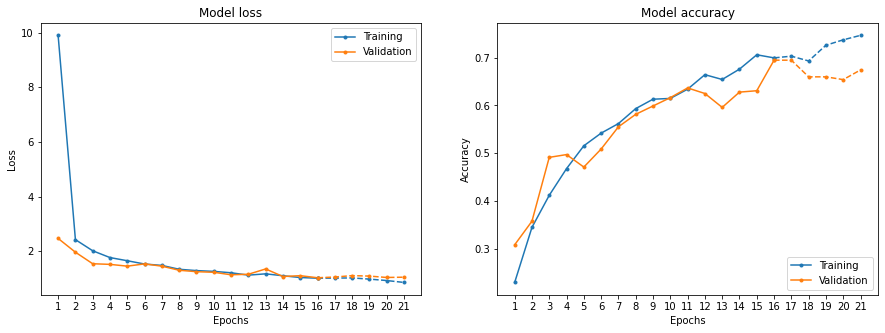

In [ ]:
plot_history(history, early_stop = e_s)

L'addestramento ha ottenuti buoni risultati infatti l'overfitting è quasi assente se si osserva il plot della loss dove la curva del training e del validation sono quasi sovrapposte.

In [ ]:
y_pred = make_prediction(vgg_tuned, test_set)


Classification Report
                        precision    recall  f1-score   support

       Albrecht Dürer       0.75      0.55      0.63        66
        Alfred Sisley       0.61      0.27      0.37        52
          Edgar Degas       0.75      0.66      0.70       140
       Francisco Goya       0.51      0.72      0.60        58
         Marc Chagall       1.00      0.42      0.59        48
        Pablo Picasso       0.64      0.60      0.62        88
         Paul Gauguin       0.50      0.63      0.56        62
Pierre-Auguste Renoir       0.78      0.42      0.54        67
            Rembrandt       0.82      0.71      0.76        52
               Titian       0.64      0.55      0.59        51
     Vincent van Gogh       0.53      0.84      0.65       175

             accuracy                           0.62       859
            macro avg       0.68      0.58      0.60       859
         weighted avg       0.66      0.62      0.62       859



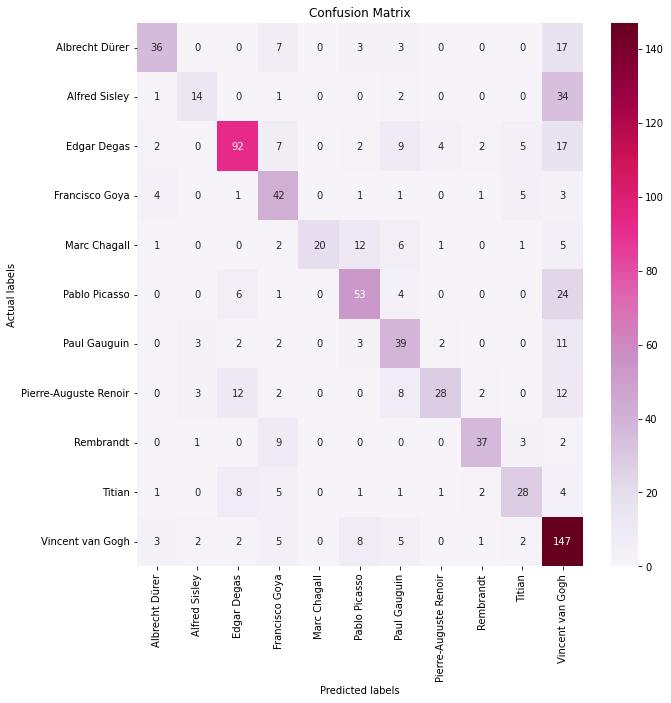

In [ ]:
evaluate_prediction(vgg_tuned, y_test, y_pred, labels, plot_size=(10,10)) 

L'accuratezza ottenuta è abbastanza elevata, infatti anche osservando la matrice di confusione osserviamo come gli errori non siano più così tanti.
Poichè però l'accuratezza non è particolarmente migliorata, decidiamo di ripetere il processo avendo come obiettivo quello di massimizzare l'accuracy sul validation set.

#### Ottimizzazione sull'accuratezza

In [ ]:
tuner = kt.BayesianOptimization(build_vgg,
                                objective = 'val_accuracy',
                                directory = './tuner',
                                max_trials = 25, overwrite = False,
                                project_name='vgg_tuning')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience = 3, min_delta = 0.001, 
                           verbose=1, restore_best_weights = True) 
tuner.search(train_set, epochs = 25, validation_data = val_set,
             shuffle = True, callbacks = [early_stop])

Trial 25 Complete [00h 14m 13s]
val_accuracy: 0.2122092992067337

Best val_accuracy So Far: 0.7180232405662537
Total elapsed time: 05h 21m 16s


In [ ]:
# Parametri ottimali
best_param = tuner.get_best_hyperparameters()[0]

print('Best parameter VGG-16: ')
best_param.values

Best parameter VGG-16: 


{'random_flip': True,
 'random_rotation': 0.0,
 'random_constrast': 0.0,
 'dense_0': 512,
 'dropout_0': 0.2,
 'dense_1': 128,
 'dropout_1': 0.2,
 'dense_2': 32,
 'dropout_2': 0.0,
 'optimizer': 'Adam',
 'lr': 0.0001}

La configurazione ottenuta è diversa dalla precedente, tra i layer di Data Augmentation è stato mantenuto il RandomFlip e anche il numero di neuroni è cambiato. L'ottimizzattore invece è rimasto uguale, mentre il learning rate in questo caso è diminuito.

In [ ]:
vgg_tuned = tuner.hypermodel.build(best_param)
vgg_tuned.save('./Model/vgg_optimized_acc.h5')

Si procede con l'addestramento e la valutazione del modello ottimizzato.

In [ ]:
history_acc, es_acc = train_model(vgg_tuned, bs = 128, eps = 50, early_stopping = True, pat = 3)

Epoch 1/50
49/49 [==============================] - 1270s 22s/step - loss: 5.2331 - accuracy: 0.2322 - val_loss: 2.0074 - val_accuracy: 0.3401
Epoch 2/50
49/49 [==============================] - 39s 714ms/step - loss: 2.5636 - accuracy: 0.3727 - val_loss: 1.6564 - val_accuracy: 0.4680
Epoch 3/50
49/49 [==============================] - 39s 714ms/step - loss: 2.1473 - accuracy: 0.4593 - val_loss: 1.4628 - val_accuracy: 0.5000
Epoch 4/50
49/49 [==============================] - 39s 714ms/step - loss: 1.7872 - accuracy: 0.5158 - val_loss: 1.3601 - val_accuracy: 0.5610
Epoch 5/50
49/49 [==============================] - 39s 712ms/step - loss: 1.5089 - accuracy: 0.6037 - val_loss: 1.1460 - val_accuracy: 0.6424
Epoch 6/50
49/49 [==============================] - 38s 709ms/step - loss: 1.2630 - accuracy: 0.6441 - val_loss: 1.0989 - val_accuracy: 0.6366
Epoch 7/50
49/49 [==============================] - 39s 711ms/step - loss: 1.1682 - accuracy: 0.6754 - val_loss: 1.0555 - val_accuracy: 0.6773

Informazioni utili: 

Numero di epoche totali: 20
Epoca migliore (weights restored): 17
Accuracy training set all'epoca 17: 0.8846899271011353
Accuracy validation set all'epoca 17: 0.7558139562606812
Loss training set all'epoca 17: 0.42059117555618286
Loss validation set all'epoca 17: 0.8634626865386963





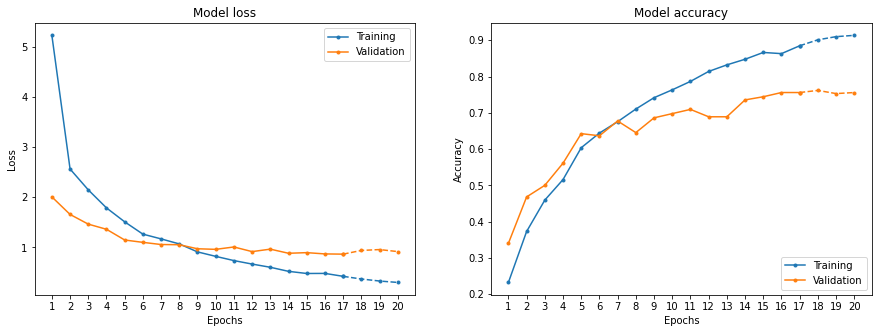

In [ ]:
plot_history(history_acc, early_stop = es_acc)

Rispetto alla versione precedente, il modello inizia a soffrire di overfitting a partire dalla nona epoca. Quindi nonostante i risultati migliori, l'altro modello globalmente ha performato meglio.

In [ ]:
y_pred = make_prediction(vgg_tuned, test_set)


Classification Report
                        precision    recall  f1-score   support

       Albrecht Dürer       0.87      0.71      0.78        66
        Alfred Sisley       0.76      0.81      0.79        52
          Edgar Degas       0.83      0.76      0.79       140
       Francisco Goya       0.70      0.67      0.68        58
         Marc Chagall       0.89      0.67      0.76        48
        Pablo Picasso       0.66      0.69      0.67        88
         Paul Gauguin       0.65      0.52      0.58        62
Pierre-Auguste Renoir       0.75      0.63      0.68        67
            Rembrandt       0.58      0.87      0.70        52
               Titian       0.69      0.57      0.62        51
     Vincent van Gogh       0.68      0.83      0.75       175

             accuracy                           0.72       859
            macro avg       0.73      0.70      0.71       859
         weighted avg       0.73      0.72      0.72       859



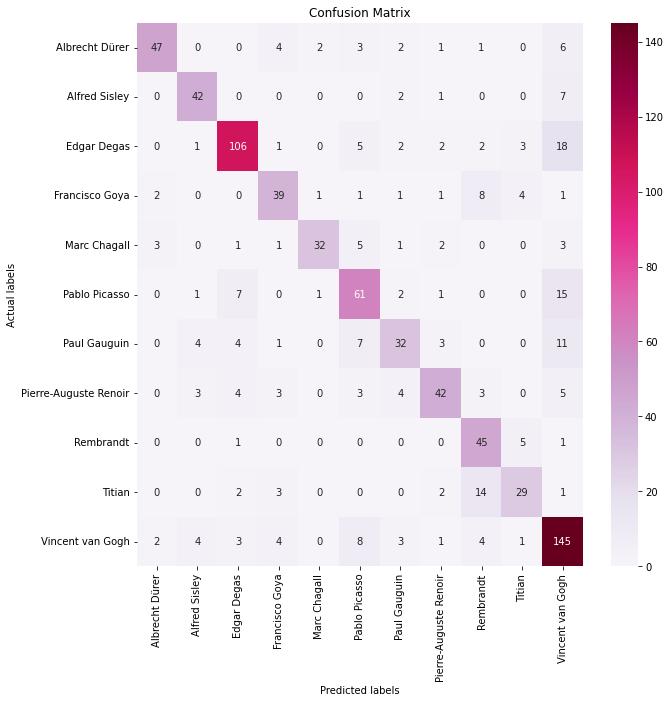

In [ ]:
evaluate_prediction(vgg_tuned, y_test, y_pred, labels, plot_size=(10,10)) 